<a href="https://colab.research.google.com/github/ostrichkim/colab/blob/main/asignment_mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 시작

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# copy folder
%cp -av /content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models /content/
%cp -av /content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/utils.py /content/

'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models' -> '/content/models'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/resnet.py' -> '/content/models/resnet.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/dla_simple.py' -> '/content/models/dla_simple.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/MobileNetV2.py' -> '/content/models/MobileNetV2.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/models/__init__.py' -> '/content/models/__init__.py'
'/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/utils.py' -> '/content/utils.py'


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import random

from models import *
random.seed(1)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [5]:
# img_size=150
img_size=112
learning_rate = 0.01
epochs = 30
weight_decay = 5e-4
momentum = 0.9
batch_size = 32
num_workers = 2
num_classes = 20

In [6]:
# # Normalize with mean and std
# from torchvision.io import read_image
# from torchvision import datasets

# # trainset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data',
# #                  transform=transforms.ToTensor())
# trainset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data_200',
#                  transform=transforms.ToTensor())
# testset = datasets.ImageFolder('/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/test_data',
#                  transform=transforms.ToTensor())

# def get_mean_and_std(dataset):
#     '''Compute the mean and std value of dataset.'''
#     dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
#     mean = torch.zeros(3)
#     std = torch.zeros(3)
#     print('==> Computing mean and std..')
#     for inputs, targets in dataloader:
#         for i in range(3):
#             mean[i] += inputs[:,i,:,:].mean()
#             std[i] += inputs[:,i,:,:].std()
#     mean.div_(len(dataset))
#     std.div_(len(dataset))
#     return mean, std

# train_mean, train_std = get_mean_and_std(trainset)
# test_mean, test_std = get_mean_and_std(testset)
# print(train_mean, train_std, '\n', test_mean, test_std)

==> Computing mean and std..


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


==> Computing mean and std..
tensor([0.5994, 0.5260, 0.4337]) tensor([0.2356, 0.2540, 0.2774]) 
 tensor([0.6083, 0.5351, 0.4456]) tensor([0.2308, 0.2525, 0.2799])


In [7]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90, expand=False),
    transforms.ColorJitter(brightness=(0.2, 3)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet standard
    # transforms.Normalize(train_mean, train_std), # Customized mean and std
])

transform_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet standard
    # transforms.Normalize(test_mean, test_std), # Customized mean and std
])

trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data', transform=transform_train)
# trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/train_data_200', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

testset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/대학원수업/[수업]딥러닝/kuaicv_assingment-main/test_data', transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

==> Preparing data..


In [8]:
# Model
print('==> Building model..')
net = MobileNetV2(num_classes)
#net = ResNet50(num_classes)
#net = SimpleDLA(num_classes=num_classes)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

==> Building model..


In [9]:
# Adjust below codes if you want to train model continuously.
if False: 
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [10]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=epochs)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [11]:
# Training
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

def train(epoch):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (batch_idx+1)%9==0:
            print("epoch : {}, Train iter : {} / {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
                epoch, 
                batch_idx+1, len(trainloader), 
                train_loss/(batch_idx+1), 
                100.*correct/total, correct, total))

    print("Train epoch : {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
        epoch, 
        train_loss/(batch_idx+1), 
        100.*correct/total, correct, total))
    train_loss_list.append(train_loss/(batch_idx+1))
    train_acc_list.append(100.*correct/total)

# Testing
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt_{}.pth'.format(epoch))
        best_acc = acc

    print("Test epoch : {}, Loss : {:.4f}, Acc : {:.2f}% | {} / {}".format(
        epoch,
        test_loss/(batch_idx+1), 
        100.*correct/total, correct, total))
    test_loss_list.append(test_loss/(batch_idx+1))
    test_acc_list.append(100.*correct/total)

In [12]:
for epoch in range(epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

epoch : 0, Train iter : 9 / 125, Loss : 3.0234, Acc : 3.12% | 9 / 288
epoch : 0, Train iter : 18 / 125, Loss : 3.0500, Acc : 3.30% | 19 / 576


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 0, Train iter : 27 / 125, Loss : 3.0465, Acc : 3.94% | 34 / 864
epoch : 0, Train iter : 36 / 125, Loss : 3.0119, Acc : 5.12% | 59 / 1152
epoch : 0, Train iter : 45 / 125, Loss : 2.9809, Acc : 5.83% | 84 / 1440
epoch : 0, Train iter : 54 / 125, Loss : 2.9660, Acc : 6.77% | 117 / 1728
epoch : 0, Train iter : 63 / 125, Loss : 2.9318, Acc : 7.64% | 154 / 2016
epoch : 0, Train iter : 72 / 125, Loss : 2.9025, Acc : 8.07% | 186 / 2304
epoch : 0, Train iter : 81 / 125, Loss : 2.8688, Acc : 8.87% | 230 / 2592
epoch : 0, Train iter : 90 / 125, Loss : 2.8533, Acc : 9.51% | 274 / 2880
epoch : 0, Train iter : 99 / 125, Loss : 2.8282, Acc : 10.42% | 330 / 3168
epoch : 0, Train iter : 108 / 125, Loss : 2.8062, Acc : 11.26% | 389 / 3456
epoch : 0, Train iter : 117 / 125, Loss : 2.8016, Acc : 11.78% | 441 / 3744
Train epoch : 0, Loss : 2.7914, Acc : 12.15% | 486 / 4000
Saving..
Test epoch : 0, Loss : 2.6425, Acc : 17.75% | 71 / 400
epoch : 1, Train iter : 9 / 125, Loss : 2.6276, Acc : 15.97% | 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 1, Train iter : 27 / 125, Loss : 2.5801, Acc : 17.01% | 147 / 864
epoch : 1, Train iter : 36 / 125, Loss : 2.5716, Acc : 18.40% | 212 / 1152


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 1, Train iter : 45 / 125, Loss : 2.5721, Acc : 19.58% | 282 / 1440
epoch : 1, Train iter : 54 / 125, Loss : 2.5614, Acc : 19.73% | 341 / 1728
epoch : 1, Train iter : 63 / 125, Loss : 2.5472, Acc : 19.89% | 401 / 2016
epoch : 1, Train iter : 72 / 125, Loss : 2.5381, Acc : 20.23% | 466 / 2304
epoch : 1, Train iter : 81 / 125, Loss : 2.5282, Acc : 20.45% | 530 / 2592
epoch : 1, Train iter : 90 / 125, Loss : 2.5260, Acc : 19.97% | 575 / 2880
epoch : 1, Train iter : 99 / 125, Loss : 2.5149, Acc : 19.95% | 632 / 3168
epoch : 1, Train iter : 108 / 125, Loss : 2.5169, Acc : 20.17% | 697 / 3456
epoch : 1, Train iter : 117 / 125, Loss : 2.5153, Acc : 20.22% | 757 / 3744
Train epoch : 1, Loss : 2.5079, Acc : 20.60% | 824 / 4000
Saving..
Test epoch : 1, Loss : 2.5488, Acc : 21.75% | 87 / 400
epoch : 2, Train iter : 9 / 125, Loss : 2.3359, Acc : 28.82% | 83 / 288
epoch : 2, Train iter : 18 / 125, Loss : 2.3531, Acc : 27.26% | 157 / 576
epoch : 2, Train iter : 27 / 125, Loss : 2.3246, Acc : 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 2, Train iter : 72 / 125, Loss : 2.2992, Acc : 27.26% | 628 / 2304
epoch : 2, Train iter : 81 / 125, Loss : 2.2884, Acc : 27.47% | 712 / 2592
epoch : 2, Train iter : 90 / 125, Loss : 2.2808, Acc : 27.47% | 791 / 2880
epoch : 2, Train iter : 99 / 125, Loss : 2.2752, Acc : 28.00% | 887 / 3168
epoch : 2, Train iter : 108 / 125, Loss : 2.2668, Acc : 28.01% | 968 / 3456
epoch : 2, Train iter : 117 / 125, Loss : 2.2575, Acc : 28.39% | 1063 / 3744
Train epoch : 2, Loss : 2.2557, Acc : 28.40% | 1136 / 4000
Saving..
Test epoch : 2, Loss : 2.0051, Acc : 36.00% | 144 / 400
epoch : 3, Train iter : 9 / 125, Loss : 2.1550, Acc : 29.86% | 86 / 288
epoch : 3, Train iter : 18 / 125, Loss : 2.2090, Acc : 28.12% | 162 / 576
epoch : 3, Train iter : 27 / 125, Loss : 2.2196, Acc : 28.94% | 250 / 864


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 3, Train iter : 36 / 125, Loss : 2.1882, Acc : 30.30% | 349 / 1152
epoch : 3, Train iter : 45 / 125, Loss : 2.1781, Acc : 30.42% | 438 / 1440
epoch : 3, Train iter : 54 / 125, Loss : 2.1602, Acc : 31.02% | 536 / 1728
epoch : 3, Train iter : 63 / 125, Loss : 2.1757, Acc : 31.15% | 628 / 2016
epoch : 3, Train iter : 72 / 125, Loss : 2.1555, Acc : 31.60% | 728 / 2304
epoch : 3, Train iter : 81 / 125, Loss : 2.1472, Acc : 32.06% | 831 / 2592
epoch : 3, Train iter : 90 / 125, Loss : 2.1432, Acc : 32.36% | 932 / 2880
epoch : 3, Train iter : 99 / 125, Loss : 2.1360, Acc : 32.73% | 1037 / 3168
epoch : 3, Train iter : 108 / 125, Loss : 2.1250, Acc : 32.84% | 1135 / 3456


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 3, Train iter : 117 / 125, Loss : 2.1205, Acc : 32.88% | 1231 / 3744
Train epoch : 3, Loss : 2.1177, Acc : 33.02% | 1321 / 4000
Saving..
Test epoch : 3, Loss : 1.9788, Acc : 38.50% | 154 / 400
epoch : 4, Train iter : 9 / 125, Loss : 2.0910, Acc : 32.64% | 94 / 288


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 4, Train iter : 18 / 125, Loss : 2.0369, Acc : 35.59% | 205 / 576
epoch : 4, Train iter : 27 / 125, Loss : 2.0264, Acc : 36.00% | 311 / 864
epoch : 4, Train iter : 36 / 125, Loss : 2.0429, Acc : 35.33% | 407 / 1152
epoch : 4, Train iter : 45 / 125, Loss : 2.0184, Acc : 35.07% | 505 / 1440
epoch : 4, Train iter : 54 / 125, Loss : 2.0155, Acc : 35.42% | 612 / 1728
epoch : 4, Train iter : 63 / 125, Loss : 1.9958, Acc : 35.86% | 723 / 2016
epoch : 4, Train iter : 72 / 125, Loss : 1.9933, Acc : 35.81% | 825 / 2304


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 4, Train iter : 81 / 125, Loss : 1.9876, Acc : 36.38% | 943 / 2592
epoch : 4, Train iter : 90 / 125, Loss : 1.9905, Acc : 36.39% | 1048 / 2880
epoch : 4, Train iter : 99 / 125, Loss : 1.9858, Acc : 36.55% | 1158 / 3168
epoch : 4, Train iter : 108 / 125, Loss : 1.9648, Acc : 36.92% | 1276 / 3456
epoch : 4, Train iter : 117 / 125, Loss : 1.9655, Acc : 37.07% | 1388 / 3744
Train epoch : 4, Loss : 1.9596, Acc : 37.20% | 1488 / 4000
Saving..
Test epoch : 4, Loss : 2.0257, Acc : 39.75% | 159 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 5, Train iter : 9 / 125, Loss : 1.9465, Acc : 38.89% | 112 / 288
epoch : 5, Train iter : 18 / 125, Loss : 1.9449, Acc : 38.02% | 219 / 576
epoch : 5, Train iter : 27 / 125, Loss : 1.9277, Acc : 37.27% | 322 / 864
epoch : 5, Train iter : 36 / 125, Loss : 1.9354, Acc : 36.89% | 425 / 1152
epoch : 5, Train iter : 45 / 125, Loss : 1.9458, Acc : 37.57% | 541 / 1440
epoch : 5, Train iter : 54 / 125, Loss : 1.9379, Acc : 37.91% | 655 / 1728
epoch : 5, Train iter : 63 / 125, Loss : 1.9266, Acc : 38.79% | 782 / 2016
epoch : 5, Train iter : 72 / 125, Loss : 1.9056, Acc : 39.11% | 901 / 2304


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 5, Train iter : 81 / 125, Loss : 1.8900, Acc : 39.58% | 1026 / 2592
epoch : 5, Train iter : 90 / 125, Loss : 1.8800, Acc : 39.34% | 1133 / 2880
epoch : 5, Train iter : 99 / 125, Loss : 1.8696, Acc : 39.77% | 1260 / 3168
epoch : 5, Train iter : 108 / 125, Loss : 1.8709, Acc : 39.67% | 1371 / 3456
epoch : 5, Train iter : 117 / 125, Loss : 1.8661, Acc : 39.98% | 1497 / 3744
Train epoch : 5, Loss : 1.8642, Acc : 40.33% | 1613 / 4000
Test epoch : 5, Loss : 2.2077, Acc : 34.75% | 139 / 400
epoch : 6, Train iter : 9 / 125, Loss : 1.8926, Acc : 38.19% | 110 / 288
epoch : 6, Train iter : 18 / 125, Loss : 1.8238, Acc : 40.45% | 233 / 576
epoch : 6, Train iter : 27 / 125, Loss : 1.8393, Acc : 40.39% | 349 / 864
epoch : 6, Train iter : 36 / 125, Loss : 1.8703, Acc : 39.41% | 454 / 1152
epoch : 6, Train iter : 45 / 125, Loss : 1.8916, Acc : 38.75% | 558 / 1440


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 6, Train iter : 54 / 125, Loss : 1.8436, Acc : 40.74% | 704 / 1728
epoch : 6, Train iter : 63 / 125, Loss : 1.8215, Acc : 41.52% | 837 / 2016
epoch : 6, Train iter : 72 / 125, Loss : 1.8101, Acc : 41.93% | 966 / 2304
epoch : 6, Train iter : 81 / 125, Loss : 1.8053, Acc : 41.86% | 1085 / 2592
epoch : 6, Train iter : 90 / 125, Loss : 1.7958, Acc : 42.36% | 1220 / 2880
epoch : 6, Train iter : 99 / 125, Loss : 1.8059, Acc : 41.95% | 1329 / 3168
epoch : 6, Train iter : 108 / 125, Loss : 1.8035, Acc : 42.22% | 1459 / 3456
epoch : 6, Train iter : 117 / 125, Loss : 1.7958, Acc : 42.33% | 1585 / 3744
Train epoch : 6, Loss : 1.7928, Acc : 42.35% | 1694 / 4000
Saving..
Test epoch : 6, Loss : 1.5854, Acc : 49.25% | 197 / 400
epoch : 7, Train iter : 9 / 125, Loss : 1.6476, Acc : 48.96% | 141 / 288
epoch : 7, Train iter : 18 / 125, Loss : 1.7229, Acc : 46.53% | 268 / 576


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 7, Train iter : 27 / 125, Loss : 1.7404, Acc : 46.53% | 402 / 864
epoch : 7, Train iter : 36 / 125, Loss : 1.7368, Acc : 45.83% | 528 / 1152
epoch : 7, Train iter : 45 / 125, Loss : 1.7397, Acc : 45.90% | 661 / 1440
epoch : 7, Train iter : 54 / 125, Loss : 1.7256, Acc : 46.41% | 802 / 1728
epoch : 7, Train iter : 63 / 125, Loss : 1.7281, Acc : 46.03% | 928 / 2016
epoch : 7, Train iter : 72 / 125, Loss : 1.7143, Acc : 46.27% | 1066 / 2304
epoch : 7, Train iter : 81 / 125, Loss : 1.7144, Acc : 45.95% | 1191 / 2592
epoch : 7, Train iter : 90 / 125, Loss : 1.6989, Acc : 46.42% | 1337 / 2880
epoch : 7, Train iter : 99 / 125, Loss : 1.6956, Acc : 46.34% | 1468 / 3168
epoch : 7, Train iter : 108 / 125, Loss : 1.6834, Acc : 46.50% | 1607 / 3456
epoch : 7, Train iter : 117 / 125, Loss : 1.6807, Acc : 46.26% | 1732 / 3744
Train epoch : 7, Loss : 1.6780, Acc : 46.30% | 1852 / 4000
Test epoch : 7, Loss : 1.7017, Acc : 48.00% | 192 / 400
epoch : 8, Train iter : 9 / 125, Loss : 1.7120, Acc :

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 8, Train iter : 45 / 125, Loss : 1.6527, Acc : 48.19% | 694 / 1440
epoch : 8, Train iter : 54 / 125, Loss : 1.6518, Acc : 47.92% | 828 / 1728
epoch : 8, Train iter : 63 / 125, Loss : 1.6407, Acc : 48.61% | 980 / 2016
epoch : 8, Train iter : 72 / 125, Loss : 1.6597, Acc : 48.31% | 1113 / 2304
epoch : 8, Train iter : 81 / 125, Loss : 1.6652, Acc : 48.11% | 1247 / 2592
epoch : 8, Train iter : 90 / 125, Loss : 1.6467, Acc : 48.40% | 1394 / 2880


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 8, Train iter : 99 / 125, Loss : 1.6432, Acc : 48.42% | 1534 / 3168
epoch : 8, Train iter : 108 / 125, Loss : 1.6394, Acc : 48.76% | 1685 / 3456
epoch : 8, Train iter : 117 / 125, Loss : 1.6361, Acc : 48.90% | 1831 / 3744
Train epoch : 8, Loss : 1.6356, Acc : 49.02% | 1961 / 4000
Test epoch : 8, Loss : 1.8189, Acc : 42.00% | 168 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 9, Train iter : 9 / 125, Loss : 1.6239, Acc : 46.53% | 134 / 288
epoch : 9, Train iter : 18 / 125, Loss : 1.5580, Acc : 49.31% | 284 / 576
epoch : 9, Train iter : 27 / 125, Loss : 1.5468, Acc : 50.58% | 437 / 864
epoch : 9, Train iter : 36 / 125, Loss : 1.5563, Acc : 50.09% | 577 / 1152
epoch : 9, Train iter : 45 / 125, Loss : 1.5428, Acc : 51.18% | 737 / 1440
epoch : 9, Train iter : 54 / 125, Loss : 1.5412, Acc : 51.56% | 891 / 1728
epoch : 9, Train iter : 63 / 125, Loss : 1.5456, Acc : 51.14% | 1031 / 2016
epoch : 9, Train iter : 72 / 125, Loss : 1.5406, Acc : 51.48% | 1186 / 2304
epoch : 9, Train iter : 81 / 125, Loss : 1.5425, Acc : 51.35% | 1331 / 2592
epoch : 9, Train iter : 90 / 125, Loss : 1.5510, Acc : 50.80% | 1463 / 2880
epoch : 9, Train iter : 99 / 125, Loss : 1.5552, Acc : 50.63% | 1604 / 3168
epoch : 9, Train iter : 108 / 125, Loss : 1.5741, Acc : 50.03% | 1729 / 3456
epoch : 9, Train iter : 117 / 125, Loss : 1.5690, Acc : 50.24% | 1881 / 3744
Train epoch : 9, Los

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 10, Train iter : 63 / 125, Loss : 1.5589, Acc : 47.92% | 966 / 2016
epoch : 10, Train iter : 72 / 125, Loss : 1.5501, Acc : 48.44% | 1116 / 2304
epoch : 10, Train iter : 81 / 125, Loss : 1.5480, Acc : 48.50% | 1257 / 2592
epoch : 10, Train iter : 90 / 125, Loss : 1.5494, Acc : 49.03% | 1412 / 2880
epoch : 10, Train iter : 99 / 125, Loss : 1.5450, Acc : 48.93% | 1550 / 3168
epoch : 10, Train iter : 108 / 125, Loss : 1.5364, Acc : 49.45% | 1709 / 3456
epoch : 10, Train iter : 117 / 125, Loss : 1.5376, Acc : 49.60% | 1857 / 3744
Train epoch : 10, Loss : 1.5315, Acc : 49.77% | 1991 / 4000
Test epoch : 10, Loss : 1.8627, Acc : 45.00% | 180 / 400
epoch : 11, Train iter : 9 / 125, Loss : 1.4581, Acc : 53.12% | 153 / 288
epoch : 11, Train iter : 18 / 125, Loss : 1.4515, Acc : 54.86% | 316 / 576


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 11, Train iter : 27 / 125, Loss : 1.4617, Acc : 55.90% | 483 / 864
epoch : 11, Train iter : 36 / 125, Loss : 1.4295, Acc : 56.16% | 647 / 1152
epoch : 11, Train iter : 45 / 125, Loss : 1.4633, Acc : 54.58% | 786 / 1440
epoch : 11, Train iter : 54 / 125, Loss : 1.4566, Acc : 54.40% | 940 / 1728
epoch : 11, Train iter : 63 / 125, Loss : 1.4595, Acc : 54.32% | 1095 / 2016
epoch : 11, Train iter : 72 / 125, Loss : 1.4463, Acc : 54.86% | 1264 / 2304
epoch : 11, Train iter : 81 / 125, Loss : 1.4386, Acc : 55.29% | 1433 / 2592
epoch : 11, Train iter : 90 / 125, Loss : 1.4261, Acc : 55.28% | 1592 / 2880
epoch : 11, Train iter : 99 / 125, Loss : 1.4230, Acc : 55.15% | 1747 / 3168
epoch : 11, Train iter : 108 / 125, Loss : 1.4285, Acc : 54.86% | 1896 / 3456


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 11, Train iter : 117 / 125, Loss : 1.4359, Acc : 54.59% | 2044 / 3744
Train epoch : 11, Loss : 1.4443, Acc : 54.20% | 2168 / 4000
Test epoch : 11, Loss : 1.8918, Acc : 41.25% | 165 / 400
epoch : 12, Train iter : 9 / 125, Loss : 1.2681, Acc : 56.25% | 162 / 288
epoch : 12, Train iter : 18 / 125, Loss : 1.3530, Acc : 52.26% | 301 / 576
epoch : 12, Train iter : 27 / 125, Loss : 1.3870, Acc : 52.20% | 451 / 864
epoch : 12, Train iter : 36 / 125, Loss : 1.4157, Acc : 52.08% | 600 / 1152
epoch : 12, Train iter : 45 / 125, Loss : 1.4382, Acc : 51.94% | 748 / 1440


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 12, Train iter : 54 / 125, Loss : 1.4483, Acc : 52.26% | 903 / 1728
epoch : 12, Train iter : 63 / 125, Loss : 1.4540, Acc : 52.38% | 1056 / 2016
epoch : 12, Train iter : 72 / 125, Loss : 1.4514, Acc : 52.65% | 1213 / 2304
epoch : 12, Train iter : 81 / 125, Loss : 1.4429, Acc : 52.78% | 1368 / 2592
epoch : 12, Train iter : 90 / 125, Loss : 1.4256, Acc : 53.16% | 1531 / 2880
epoch : 12, Train iter : 99 / 125, Loss : 1.4181, Acc : 53.63% | 1699 / 3168
epoch : 12, Train iter : 108 / 125, Loss : 1.4283, Acc : 53.56% | 1851 / 3456
epoch : 12, Train iter : 117 / 125, Loss : 1.4206, Acc : 53.79% | 2014 / 3744
Train epoch : 12, Loss : 1.4211, Acc : 53.77% | 2151 / 4000
Saving..
Test epoch : 12, Loss : 1.4637, Acc : 55.50% | 222 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 13, Train iter : 9 / 125, Loss : 1.3823, Acc : 53.12% | 153 / 288
epoch : 13, Train iter : 18 / 125, Loss : 1.3244, Acc : 56.42% | 325 / 576
epoch : 13, Train iter : 27 / 125, Loss : 1.3855, Acc : 55.79% | 482 / 864
epoch : 13, Train iter : 36 / 125, Loss : 1.3796, Acc : 55.73% | 642 / 1152
epoch : 13, Train iter : 45 / 125, Loss : 1.3598, Acc : 56.88% | 819 / 1440
epoch : 13, Train iter : 54 / 125, Loss : 1.3787, Acc : 56.37% | 974 / 1728
epoch : 13, Train iter : 63 / 125, Loss : 1.3574, Acc : 56.94% | 1148 / 2016
epoch : 13, Train iter : 72 / 125, Loss : 1.3412, Acc : 57.25% | 1319 / 2304
epoch : 13, Train iter : 81 / 125, Loss : 1.3552, Acc : 56.71% | 1470 / 2592
epoch : 13, Train iter : 90 / 125, Loss : 1.3534, Acc : 56.56% | 1629 / 2880
epoch : 13, Train iter : 99 / 125, Loss : 1.3556, Acc : 56.44% | 1788 / 3168
epoch : 13, Train iter : 108 / 125, Loss : 1.3589, Acc : 56.13% | 1940 / 3456
epoch : 13, Train iter : 117 / 125, Loss : 1.3706, Acc : 55.80% | 2089 / 3744
Train e

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 14, Train iter : 9 / 125, Loss : 1.5423, Acc : 49.65% | 143 / 288
epoch : 14, Train iter : 18 / 125, Loss : 1.4637, Acc : 51.74% | 298 / 576
epoch : 14, Train iter : 27 / 125, Loss : 1.4313, Acc : 53.70% | 464 / 864
epoch : 14, Train iter : 36 / 125, Loss : 1.3758, Acc : 55.99% | 645 / 1152
epoch : 14, Train iter : 45 / 125, Loss : 1.3381, Acc : 57.22% | 824 / 1440
epoch : 14, Train iter : 54 / 125, Loss : 1.3519, Acc : 56.83% | 982 / 1728


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 14, Train iter : 63 / 125, Loss : 1.3505, Acc : 56.99% | 1149 / 2016
epoch : 14, Train iter : 72 / 125, Loss : 1.3603, Acc : 56.42% | 1300 / 2304
epoch : 14, Train iter : 81 / 125, Loss : 1.3572, Acc : 56.33% | 1460 / 2592
epoch : 14, Train iter : 90 / 125, Loss : 1.3578, Acc : 56.35% | 1623 / 2880
epoch : 14, Train iter : 99 / 125, Loss : 1.3544, Acc : 56.47% | 1789 / 3168
epoch : 14, Train iter : 108 / 125, Loss : 1.3521, Acc : 56.57% | 1955 / 3456
epoch : 14, Train iter : 117 / 125, Loss : 1.3403, Acc : 56.78% | 2126 / 3744
Train epoch : 14, Loss : 1.3387, Acc : 56.80% | 2272 / 4000
Saving..
Test epoch : 14, Loss : 1.2761, Acc : 59.25% | 237 / 400
epoch : 15, Train iter : 9 / 125, Loss : 1.2502, Acc : 58.33% | 168 / 288
epoch : 15, Train iter : 18 / 125, Loss : 1.2862, Acc : 57.99% | 334 / 576
epoch : 15, Train iter : 27 / 125, Loss : 1.2958, Acc : 58.10% | 502 / 864
epoch : 15, Train iter : 36 / 125, Loss : 1.2828, Acc : 58.42% | 673 / 1152


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 15, Train iter : 45 / 125, Loss : 1.2565, Acc : 59.10% | 851 / 1440
epoch : 15, Train iter : 54 / 125, Loss : 1.2378, Acc : 59.38% | 1026 / 1728
epoch : 15, Train iter : 63 / 125, Loss : 1.2253, Acc : 59.18% | 1193 / 2016
epoch : 15, Train iter : 72 / 125, Loss : 1.2327, Acc : 58.72% | 1353 / 2304
epoch : 15, Train iter : 81 / 125, Loss : 1.2379, Acc : 58.56% | 1518 / 2592
epoch : 15, Train iter : 90 / 125, Loss : 1.2407, Acc : 58.54% | 1686 / 2880
epoch : 15, Train iter : 99 / 125, Loss : 1.2465, Acc : 58.55% | 1855 / 3168
epoch : 15, Train iter : 108 / 125, Loss : 1.2481, Acc : 58.91% | 2036 / 3456
epoch : 15, Train iter : 117 / 125, Loss : 1.2598, Acc : 58.63% | 2195 / 3744


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Train epoch : 15, Loss : 1.2586, Acc : 58.77% | 2351 / 4000
Test epoch : 15, Loss : 1.3950, Acc : 57.75% | 231 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 16, Train iter : 9 / 125, Loss : 1.3242, Acc : 58.68% | 169 / 288
epoch : 16, Train iter : 18 / 125, Loss : 1.3038, Acc : 58.68% | 338 / 576
epoch : 16, Train iter : 27 / 125, Loss : 1.2897, Acc : 58.33% | 504 / 864
epoch : 16, Train iter : 36 / 125, Loss : 1.2855, Acc : 57.99% | 668 / 1152
epoch : 16, Train iter : 45 / 125, Loss : 1.2965, Acc : 57.50% | 828 / 1440
epoch : 16, Train iter : 54 / 125, Loss : 1.2846, Acc : 57.75% | 998 / 1728
epoch : 16, Train iter : 63 / 125, Loss : 1.2698, Acc : 58.68% | 1183 / 2016
epoch : 16, Train iter : 72 / 125, Loss : 1.2480, Acc : 59.55% | 1372 / 2304
epoch : 16, Train iter : 81 / 125, Loss : 1.2446, Acc : 59.72% | 1548 / 2592
epoch : 16, Train iter : 90 / 125, Loss : 1.2290, Acc : 60.00% | 1728 / 2880
epoch : 16, Train iter : 99 / 125, Loss : 1.2313, Acc : 60.20% | 1907 / 3168
epoch : 16, Train iter : 108 / 125, Loss : 1.2218, Acc : 60.68% | 2097 / 3456
epoch : 16, Train iter : 117 / 125, Loss : 1.2168, Acc : 60.82% | 2277 / 3744
Train e

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 17, Train iter : 9 / 125, Loss : 1.1226, Acc : 62.85% | 181 / 288
epoch : 17, Train iter : 18 / 125, Loss : 1.1283, Acc : 63.54% | 366 / 576
epoch : 17, Train iter : 27 / 125, Loss : 1.1347, Acc : 63.31% | 547 / 864
epoch : 17, Train iter : 36 / 125, Loss : 1.1582, Acc : 61.98% | 714 / 1152
epoch : 17, Train iter : 45 / 125, Loss : 1.1564, Acc : 61.88% | 891 / 1440
epoch : 17, Train iter : 54 / 125, Loss : 1.1716, Acc : 61.28% | 1059 / 1728
epoch : 17, Train iter : 63 / 125, Loss : 1.1940, Acc : 60.71% | 1224 / 2016
epoch : 17, Train iter : 72 / 125, Loss : 1.2043, Acc : 60.89% | 1403 / 2304
epoch : 17, Train iter : 81 / 125, Loss : 1.2025, Acc : 60.76% | 1575 / 2592
epoch : 17, Train iter : 90 / 125, Loss : 1.2076, Acc : 60.80% | 1751 / 2880
epoch : 17, Train iter : 99 / 125, Loss : 1.2121, Acc : 60.54% | 1918 / 3168
epoch : 17, Train iter : 108 / 125, Loss : 1.2105, Acc : 60.50% | 2091 / 3456
epoch : 17, Train iter : 117 / 125, Loss : 1.2170, Acc : 60.23% | 2255 / 3744
Train 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 18, Train iter : 45 / 125, Loss : 1.1957, Acc : 60.14% | 866 / 1440
epoch : 18, Train iter : 54 / 125, Loss : 1.1916, Acc : 60.47% | 1045 / 1728
epoch : 18, Train iter : 63 / 125, Loss : 1.1996, Acc : 60.47% | 1219 / 2016


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 18, Train iter : 72 / 125, Loss : 1.2031, Acc : 60.42% | 1392 / 2304
epoch : 18, Train iter : 81 / 125, Loss : 1.2053, Acc : 60.19% | 1560 / 2592
epoch : 18, Train iter : 90 / 125, Loss : 1.2030, Acc : 60.28% | 1736 / 2880
epoch : 18, Train iter : 99 / 125, Loss : 1.2021, Acc : 60.39% | 1913 / 3168
epoch : 18, Train iter : 108 / 125, Loss : 1.1948, Acc : 60.71% | 2098 / 3456
epoch : 18, Train iter : 117 / 125, Loss : 1.1989, Acc : 60.52% | 2266 / 3744
Train epoch : 18, Loss : 1.2002, Acc : 60.55% | 2422 / 4000
Saving..
Test epoch : 18, Loss : 1.1768, Acc : 64.75% | 259 / 400
epoch : 19, Train iter : 9 / 125, Loss : 1.1885, Acc : 58.33% | 168 / 288
epoch : 19, Train iter : 18 / 125, Loss : 1.1007, Acc : 62.67% | 361 / 576
epoch : 19, Train iter : 27 / 125, Loss : 1.0976, Acc : 63.43% | 548 / 864
epoch : 19, Train iter : 36 / 125, Loss : 1.0766, Acc : 63.80% | 735 / 1152


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 19, Train iter : 45 / 125, Loss : 1.1082, Acc : 63.61% | 916 / 1440
epoch : 19, Train iter : 54 / 125, Loss : 1.1105, Acc : 63.25% | 1093 / 1728
epoch : 19, Train iter : 63 / 125, Loss : 1.1156, Acc : 62.80% | 1266 / 2016
epoch : 19, Train iter : 72 / 125, Loss : 1.1288, Acc : 62.59% | 1442 / 2304
epoch : 19, Train iter : 81 / 125, Loss : 1.1374, Acc : 62.35% | 1616 / 2592
epoch : 19, Train iter : 90 / 125, Loss : 1.1477, Acc : 62.08% | 1788 / 2880
epoch : 19, Train iter : 99 / 125, Loss : 1.1433, Acc : 62.15% | 1969 / 3168
epoch : 19, Train iter : 108 / 125, Loss : 1.1430, Acc : 62.01% | 2143 / 3456
epoch : 19, Train iter : 117 / 125, Loss : 1.1475, Acc : 61.89% | 2317 / 3744


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Train epoch : 19, Loss : 1.1463, Acc : 61.83% | 2473 / 4000
Test epoch : 19, Loss : 1.3041, Acc : 62.50% | 250 / 400
epoch : 20, Train iter : 9 / 125, Loss : 1.1688, Acc : 59.03% | 170 / 288
epoch : 20, Train iter : 18 / 125, Loss : 1.1234, Acc : 61.28% | 353 / 576
epoch : 20, Train iter : 27 / 125, Loss : 1.1173, Acc : 61.23% | 529 / 864


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 20, Train iter : 36 / 125, Loss : 1.1206, Acc : 62.24% | 717 / 1152
epoch : 20, Train iter : 45 / 125, Loss : 1.1016, Acc : 62.50% | 900 / 1440
epoch : 20, Train iter : 54 / 125, Loss : 1.0999, Acc : 63.14% | 1091 / 1728
epoch : 20, Train iter : 63 / 125, Loss : 1.0750, Acc : 63.94% | 1289 / 2016
epoch : 20, Train iter : 72 / 125, Loss : 1.0855, Acc : 63.06% | 1453 / 2304
epoch : 20, Train iter : 81 / 125, Loss : 1.0972, Acc : 62.96% | 1632 / 2592
epoch : 20, Train iter : 90 / 125, Loss : 1.1000, Acc : 62.71% | 1806 / 2880
epoch : 20, Train iter : 99 / 125, Loss : 1.0944, Acc : 62.97% | 1995 / 3168
epoch : 20, Train iter : 108 / 125, Loss : 1.0937, Acc : 63.11% | 2181 / 3456
epoch : 20, Train iter : 117 / 125, Loss : 1.0920, Acc : 63.17% | 2365 / 3744
Train epoch : 20, Loss : 1.0922, Acc : 63.20% | 2528 / 4000
Test epoch : 20, Loss : 1.2603, Acc : 60.00% | 240 / 400
epoch : 21, Train iter : 9 / 125, Loss : 1.0372, Acc : 65.62% | 189 / 288
epoch : 21, Train iter : 18 / 125, Loss

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 21, Train iter : 45 / 125, Loss : 1.0498, Acc : 65.35% | 941 / 1440
epoch : 21, Train iter : 54 / 125, Loss : 1.0653, Acc : 64.53% | 1115 / 1728
epoch : 21, Train iter : 63 / 125, Loss : 1.0866, Acc : 63.94% | 1289 / 2016
epoch : 21, Train iter : 72 / 125, Loss : 1.0736, Acc : 64.11% | 1477 / 2304
epoch : 21, Train iter : 81 / 125, Loss : 1.0861, Acc : 63.62% | 1649 / 2592
epoch : 21, Train iter : 90 / 125, Loss : 1.0719, Acc : 64.20% | 1849 / 2880
epoch : 21, Train iter : 99 / 125, Loss : 1.0912, Acc : 63.83% | 2022 / 3168
epoch : 21, Train iter : 108 / 125, Loss : 1.0920, Acc : 63.95% | 2210 / 3456
epoch : 21, Train iter : 117 / 125, Loss : 1.0908, Acc : 64.05% | 2398 / 3744
Train epoch : 21, Loss : 1.0918, Acc : 63.92% | 2557 / 4000
Test epoch : 21, Loss : 1.2099, Acc : 63.00% | 252 / 400
epoch : 22, Train iter : 9 / 125, Loss : 0.9802, Acc : 66.32% | 191 / 288


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 22, Train iter : 18 / 125, Loss : 1.0120, Acc : 66.49% | 383 / 576
epoch : 22, Train iter : 27 / 125, Loss : 1.0275, Acc : 65.74% | 568 / 864
epoch : 22, Train iter : 36 / 125, Loss : 1.0363, Acc : 65.45% | 754 / 1152
epoch : 22, Train iter : 45 / 125, Loss : 1.0249, Acc : 65.69% | 946 / 1440
epoch : 22, Train iter : 54 / 125, Loss : 1.0249, Acc : 65.74% | 1136 / 1728
epoch : 22, Train iter : 63 / 125, Loss : 1.0233, Acc : 65.97% | 1330 / 2016
epoch : 22, Train iter : 72 / 125, Loss : 0.9984, Acc : 66.93% | 1542 / 2304
epoch : 22, Train iter : 81 / 125, Loss : 1.0264, Acc : 66.09% | 1713 / 2592
epoch : 22, Train iter : 90 / 125, Loss : 1.0302, Acc : 65.94% | 1899 / 2880
epoch : 22, Train iter : 99 / 125, Loss : 1.0298, Acc : 65.85% | 2086 / 3168
epoch : 22, Train iter : 108 / 125, Loss : 1.0368, Acc : 65.28% | 2256 / 3456
epoch : 22, Train iter : 117 / 125, Loss : 1.0499, Acc : 64.80% | 2426 / 3744
Train epoch : 22, Loss : 1.0526, Acc : 64.90% | 2596 / 4000
Test epoch : 22, Los

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 23, Train iter : 9 / 125, Loss : 0.9921, Acc : 67.36% | 194 / 288
epoch : 23, Train iter : 18 / 125, Loss : 0.9877, Acc : 68.23% | 393 / 576
epoch : 23, Train iter : 27 / 125, Loss : 0.9539, Acc : 70.25% | 607 / 864
epoch : 23, Train iter : 36 / 125, Loss : 0.9449, Acc : 69.97% | 806 / 1152
epoch : 23, Train iter : 45 / 125, Loss : 0.9610, Acc : 69.24% | 997 / 1440
epoch : 23, Train iter : 54 / 125, Loss : 0.9728, Acc : 68.58% | 1185 / 1728
epoch : 23, Train iter : 63 / 125, Loss : 0.9653, Acc : 68.70% | 1385 / 2016
epoch : 23, Train iter : 72 / 125, Loss : 0.9822, Acc : 68.36% | 1575 / 2304
epoch : 23, Train iter : 81 / 125, Loss : 1.0059, Acc : 67.48% | 1749 / 2592
epoch : 23, Train iter : 90 / 125, Loss : 1.0142, Acc : 67.36% | 1940 / 2880


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 23, Train iter : 99 / 125, Loss : 1.0251, Acc : 67.05% | 2124 / 3168
epoch : 23, Train iter : 108 / 125, Loss : 1.0292, Acc : 66.90% | 2312 / 3456
epoch : 23, Train iter : 117 / 125, Loss : 1.0257, Acc : 67.23% | 2517 / 3744
Train epoch : 23, Loss : 1.0329, Acc : 66.95% | 2678 / 4000
Test epoch : 23, Loss : 1.1743, Acc : 60.25% | 241 / 400
epoch : 24, Train iter : 9 / 125, Loss : 0.8620, Acc : 69.79% | 201 / 288
epoch : 24, Train iter : 18 / 125, Loss : 0.9536, Acc : 70.14% | 404 / 576
epoch : 24, Train iter : 27 / 125, Loss : 0.9720, Acc : 67.94% | 587 / 864


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 24, Train iter : 36 / 125, Loss : 0.9834, Acc : 67.45% | 777 / 1152
epoch : 24, Train iter : 45 / 125, Loss : 0.9985, Acc : 66.46% | 957 / 1440
epoch : 24, Train iter : 54 / 125, Loss : 1.0070, Acc : 66.38% | 1147 / 1728
epoch : 24, Train iter : 63 / 125, Loss : 1.0145, Acc : 66.22% | 1335 / 2016
epoch : 24, Train iter : 72 / 125, Loss : 1.0129, Acc : 66.23% | 1526 / 2304
epoch : 24, Train iter : 81 / 125, Loss : 1.0117, Acc : 66.28% | 1718 / 2592
epoch : 24, Train iter : 90 / 125, Loss : 1.0154, Acc : 66.42% | 1913 / 2880
epoch : 24, Train iter : 99 / 125, Loss : 1.0140, Acc : 66.73% | 2114 / 3168
epoch : 24, Train iter : 108 / 125, Loss : 1.0117, Acc : 66.93% | 2313 / 3456
epoch : 24, Train iter : 117 / 125, Loss : 1.0048, Acc : 66.99% | 2508 / 3744
Train epoch : 24, Loss : 1.0063, Acc : 66.88% | 2675 / 4000
Test epoch : 24, Loss : 2.0728, Acc : 48.75% | 195 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 25, Train iter : 9 / 125, Loss : 1.0330, Acc : 68.40% | 197 / 288
epoch : 25, Train iter : 18 / 125, Loss : 1.0079, Acc : 67.88% | 391 / 576
epoch : 25, Train iter : 27 / 125, Loss : 1.0565, Acc : 66.32% | 573 / 864
epoch : 25, Train iter : 36 / 125, Loss : 1.0489, Acc : 66.32% | 764 / 1152
epoch : 25, Train iter : 45 / 125, Loss : 1.0390, Acc : 66.53% | 958 / 1440
epoch : 25, Train iter : 54 / 125, Loss : 1.0280, Acc : 66.96% | 1157 / 1728


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 25, Train iter : 63 / 125, Loss : 1.0403, Acc : 66.32% | 1337 / 2016
epoch : 25, Train iter : 72 / 125, Loss : 1.0388, Acc : 66.58% | 1534 / 2304
epoch : 25, Train iter : 81 / 125, Loss : 1.0299, Acc : 66.71% | 1729 / 2592
epoch : 25, Train iter : 90 / 125, Loss : 1.0212, Acc : 66.98% | 1929 / 2880
epoch : 25, Train iter : 99 / 125, Loss : 1.0168, Acc : 66.95% | 2121 / 3168
epoch : 25, Train iter : 108 / 125, Loss : 1.0123, Acc : 66.96% | 2314 / 3456
epoch : 25, Train iter : 117 / 125, Loss : 1.0027, Acc : 67.36% | 2522 / 3744
Train epoch : 25, Loss : 1.0032, Acc : 67.45% | 2698 / 4000
Test epoch : 25, Loss : 1.1890, Acc : 63.25% | 253 / 400
epoch : 26, Train iter : 9 / 125, Loss : 0.9653, Acc : 67.36% | 194 / 288


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 26, Train iter : 18 / 125, Loss : 1.0096, Acc : 67.53% | 389 / 576
epoch : 26, Train iter : 27 / 125, Loss : 0.9859, Acc : 68.52% | 592 / 864
epoch : 26, Train iter : 36 / 125, Loss : 0.9558, Acc : 69.18% | 797 / 1152
epoch : 26, Train iter : 45 / 125, Loss : 0.9568, Acc : 69.10% | 995 / 1440
epoch : 26, Train iter : 54 / 125, Loss : 0.9642, Acc : 68.87% | 1190 / 1728
epoch : 26, Train iter : 63 / 125, Loss : 0.9588, Acc : 69.25% | 1396 / 2016
epoch : 26, Train iter : 72 / 125, Loss : 0.9493, Acc : 69.53% | 1602 / 2304
epoch : 26, Train iter : 81 / 125, Loss : 0.9494, Acc : 69.21% | 1794 / 2592
epoch : 26, Train iter : 90 / 125, Loss : 0.9510, Acc : 69.38% | 1998 / 2880
epoch : 26, Train iter : 99 / 125, Loss : 0.9380, Acc : 69.70% | 2208 / 3168
epoch : 26, Train iter : 108 / 125, Loss : 0.9459, Acc : 69.36% | 2397 / 3456
epoch : 26, Train iter : 117 / 125, Loss : 0.9425, Acc : 69.44% | 2600 / 3744
Train epoch : 26, Loss : 0.9502, Acc : 69.30% | 2772 / 4000
Saving..
Test epoch 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 27, Train iter : 18 / 125, Loss : 0.9004, Acc : 71.18% | 410 / 576
epoch : 27, Train iter : 27 / 125, Loss : 0.9053, Acc : 70.14% | 606 / 864
epoch : 27, Train iter : 36 / 125, Loss : 0.8987, Acc : 70.83% | 816 / 1152
epoch : 27, Train iter : 45 / 125, Loss : 0.8841, Acc : 71.32% | 1027 / 1440
epoch : 27, Train iter : 54 / 125, Loss : 0.8783, Acc : 71.64% | 1238 / 1728
epoch : 27, Train iter : 63 / 125, Loss : 0.8816, Acc : 71.13% | 1434 / 2016
epoch : 27, Train iter : 72 / 125, Loss : 0.8851, Acc : 71.22% | 1641 / 2304
epoch : 27, Train iter : 81 / 125, Loss : 0.8903, Acc : 70.83% | 1836 / 2592
epoch : 27, Train iter : 90 / 125, Loss : 0.8943, Acc : 70.73% | 2037 / 2880
epoch : 27, Train iter : 99 / 125, Loss : 0.9018, Acc : 70.45% | 2232 / 3168
epoch : 27, Train iter : 108 / 125, Loss : 0.9056, Acc : 70.40% | 2433 / 3456
epoch : 27, Train iter : 117 / 125, Loss : 0.9081, Acc : 70.09% | 2624 / 3744
Train epoch : 27, Loss : 0.9145, Acc : 69.75% | 2790 / 4000
Saving..
Test epoch

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 28, Train iter : 18 / 125, Loss : 0.8331, Acc : 73.61% | 424 / 576
epoch : 28, Train iter : 27 / 125, Loss : 0.8704, Acc : 70.83% | 612 / 864
epoch : 28, Train iter : 36 / 125, Loss : 0.9078, Acc : 69.53% | 801 / 1152


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 28, Train iter : 45 / 125, Loss : 0.9058, Acc : 69.38% | 999 / 1440
epoch : 28, Train iter : 54 / 125, Loss : 0.9133, Acc : 69.68% | 1204 / 1728
epoch : 28, Train iter : 63 / 125, Loss : 0.9188, Acc : 70.09% | 1413 / 2016
epoch : 28, Train iter : 72 / 125, Loss : 0.9196, Acc : 70.05% | 1614 / 2304
epoch : 28, Train iter : 81 / 125, Loss : 0.9151, Acc : 70.06% | 1816 / 2592
epoch : 28, Train iter : 90 / 125, Loss : 0.9125, Acc : 70.17% | 2021 / 2880
epoch : 28, Train iter : 99 / 125, Loss : 0.9060, Acc : 70.17% | 2223 / 3168
epoch : 28, Train iter : 108 / 125, Loss : 0.9060, Acc : 70.28% | 2429 / 3456
epoch : 28, Train iter : 117 / 125, Loss : 0.9132, Acc : 70.09% | 2624 / 3744
Train epoch : 28, Loss : 0.9177, Acc : 69.92% | 2797 / 4000
Test epoch : 28, Loss : 0.9397, Acc : 72.00% | 288 / 400
epoch : 29, Train iter : 9 / 125, Loss : 0.8225, Acc : 73.96% | 213 / 288
epoch : 29, Train iter : 18 / 125, Loss : 0.8492, Acc : 70.83% | 408 / 576
epoch : 29, Train iter : 27 / 125, Loss 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 29, Train iter : 36 / 125, Loss : 0.9002, Acc : 69.79% | 804 / 1152
epoch : 29, Train iter : 45 / 125, Loss : 0.8929, Acc : 70.49% | 1015 / 1440
epoch : 29, Train iter : 54 / 125, Loss : 0.8840, Acc : 70.66% | 1221 / 1728
epoch : 29, Train iter : 63 / 125, Loss : 0.8840, Acc : 70.93% | 1430 / 2016
epoch : 29, Train iter : 72 / 125, Loss : 0.8711, Acc : 71.40% | 1645 / 2304
epoch : 29, Train iter : 81 / 125, Loss : 0.8607, Acc : 71.57% | 1855 / 2592
epoch : 29, Train iter : 90 / 125, Loss : 0.8741, Acc : 71.08% | 2047 / 2880
epoch : 29, Train iter : 99 / 125, Loss : 0.8765, Acc : 70.86% | 2245 / 3168
epoch : 29, Train iter : 108 / 125, Loss : 0.8910, Acc : 70.66% | 2442 / 3456
epoch : 29, Train iter : 117 / 125, Loss : 0.8900, Acc : 70.57% | 2642 / 3744
Train epoch : 29, Loss : 0.8905, Acc : 70.53% | 2821 / 4000
Test epoch : 29, Loss : 0.8753, Acc : 70.00% | 280 / 400
epoch : 30, Train iter : 9 / 125, Loss : 0.8759, Acc : 70.49% | 203 / 288
epoch : 30, Train iter : 18 / 125, Los

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 30, Train iter : 54 / 125, Loss : 0.8497, Acc : 71.88% | 1242 / 1728
epoch : 30, Train iter : 63 / 125, Loss : 0.8484, Acc : 71.88% | 1449 / 2016
epoch : 30, Train iter : 72 / 125, Loss : 0.8554, Acc : 71.61% | 1650 / 2304
epoch : 30, Train iter : 81 / 125, Loss : 0.8592, Acc : 71.30% | 1848 / 2592


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 30, Train iter : 90 / 125, Loss : 0.8609, Acc : 71.18% | 2050 / 2880
epoch : 30, Train iter : 99 / 125, Loss : 0.8638, Acc : 70.93% | 2247 / 3168
epoch : 30, Train iter : 108 / 125, Loss : 0.8750, Acc : 70.66% | 2442 / 3456
epoch : 30, Train iter : 117 / 125, Loss : 0.8893, Acc : 70.25% | 2630 / 3744
Train epoch : 30, Loss : 0.8872, Acc : 70.28% | 2811 / 4000
Test epoch : 30, Loss : 0.9648, Acc : 69.50% | 278 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 31, Train iter : 9 / 125, Loss : 0.7784, Acc : 75.69% | 218 / 288
epoch : 31, Train iter : 18 / 125, Loss : 0.8326, Acc : 74.31% | 428 / 576
epoch : 31, Train iter : 27 / 125, Loss : 0.8037, Acc : 75.69% | 654 / 864
epoch : 31, Train iter : 36 / 125, Loss : 0.7971, Acc : 75.43% | 869 / 1152
epoch : 31, Train iter : 45 / 125, Loss : 0.8061, Acc : 74.79% | 1077 / 1440
epoch : 31, Train iter : 54 / 125, Loss : 0.8028, Acc : 75.17% | 1299 / 1728
epoch : 31, Train iter : 63 / 125, Loss : 0.8073, Acc : 74.50% | 1502 / 2016
epoch : 31, Train iter : 72 / 125, Loss : 0.8127, Acc : 74.26% | 1711 / 2304
epoch : 31, Train iter : 81 / 125, Loss : 0.8259, Acc : 73.57% | 1907 / 2592
epoch : 31, Train iter : 90 / 125, Loss : 0.8354, Acc : 73.37% | 2113 / 2880
epoch : 31, Train iter : 99 / 125, Loss : 0.8533, Acc : 72.63% | 2301 / 3168
epoch : 31, Train iter : 108 / 125, Loss : 0.8594, Acc : 72.37% | 2501 / 3456
epoch : 31, Train iter : 117 / 125, Loss : 0.8653, Acc : 72.22% | 2704 / 3744
Train

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 32, Train iter : 81 / 125, Loss : 0.8053, Acc : 73.26% | 1899 / 2592
epoch : 32, Train iter : 90 / 125, Loss : 0.8007, Acc : 73.58% | 2119 / 2880


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 32, Train iter : 99 / 125, Loss : 0.8140, Acc : 73.20% | 2319 / 3168
epoch : 32, Train iter : 108 / 125, Loss : 0.8187, Acc : 73.06% | 2525 / 3456
epoch : 32, Train iter : 117 / 125, Loss : 0.8089, Acc : 73.40% | 2748 / 3744
Train epoch : 32, Loss : 0.8151, Acc : 73.10% | 2924 / 4000
Test epoch : 32, Loss : 0.8595, Acc : 71.25% | 285 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 33, Train iter : 9 / 125, Loss : 0.8252, Acc : 70.83% | 204 / 288
epoch : 33, Train iter : 18 / 125, Loss : 0.8053, Acc : 72.22% | 416 / 576
epoch : 33, Train iter : 27 / 125, Loss : 0.8589, Acc : 71.18% | 615 / 864
epoch : 33, Train iter : 36 / 125, Loss : 0.8382, Acc : 72.22% | 832 / 1152
epoch : 33, Train iter : 45 / 125, Loss : 0.8287, Acc : 72.36% | 1042 / 1440
epoch : 33, Train iter : 54 / 125, Loss : 0.8318, Acc : 72.34% | 1250 / 1728
epoch : 33, Train iter : 63 / 125, Loss : 0.8266, Acc : 72.52% | 1462 / 2016
epoch : 33, Train iter : 72 / 125, Loss : 0.8216, Acc : 72.87% | 1679 / 2304
epoch : 33, Train iter : 81 / 125, Loss : 0.8302, Acc : 72.49% | 1879 / 2592
epoch : 33, Train iter : 90 / 125, Loss : 0.8201, Acc : 72.95% | 2101 / 2880
epoch : 33, Train iter : 99 / 125, Loss : 0.8151, Acc : 73.17% | 2318 / 3168


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 33, Train iter : 108 / 125, Loss : 0.8087, Acc : 73.47% | 2539 / 3456
epoch : 33, Train iter : 117 / 125, Loss : 0.7979, Acc : 73.74% | 2761 / 3744
Train epoch : 33, Loss : 0.7999, Acc : 73.58% | 2943 / 4000
Saving..
Test epoch : 33, Loss : 0.8034, Acc : 74.50% | 298 / 400
epoch : 34, Train iter : 9 / 125, Loss : 0.7327, Acc : 75.35% | 217 / 288
epoch : 34, Train iter : 18 / 125, Loss : 0.7568, Acc : 75.00% | 432 / 576
epoch : 34, Train iter : 27 / 125, Loss : 0.7664, Acc : 74.19% | 641 / 864
epoch : 34, Train iter : 36 / 125, Loss : 0.7809, Acc : 74.22% | 855 / 1152


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 34, Train iter : 45 / 125, Loss : 0.7785, Acc : 74.10% | 1067 / 1440
epoch : 34, Train iter : 54 / 125, Loss : 0.7834, Acc : 73.61% | 1272 / 1728
epoch : 34, Train iter : 63 / 125, Loss : 0.7914, Acc : 73.51% | 1482 / 2016
epoch : 34, Train iter : 72 / 125, Loss : 0.8005, Acc : 73.26% | 1688 / 2304


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 34, Train iter : 81 / 125, Loss : 0.7991, Acc : 73.57% | 1907 / 2592
epoch : 34, Train iter : 90 / 125, Loss : 0.8061, Acc : 73.02% | 2103 / 2880
epoch : 34, Train iter : 99 / 125, Loss : 0.8150, Acc : 72.82% | 2307 / 3168
epoch : 34, Train iter : 108 / 125, Loss : 0.8156, Acc : 72.97% | 2522 / 3456
epoch : 34, Train iter : 117 / 125, Loss : 0.8298, Acc : 72.62% | 2719 / 3744
Train epoch : 34, Loss : 0.8303, Acc : 72.47% | 2899 / 4000
Test epoch : 34, Loss : 1.2926, Acc : 63.50% | 254 / 400
epoch : 35, Train iter : 9 / 125, Loss : 0.7289, Acc : 75.69% | 218 / 288
epoch : 35, Train iter : 18 / 125, Loss : 0.7670, Acc : 75.17% | 433 / 576


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 35, Train iter : 27 / 125, Loss : 0.7168, Acc : 75.93% | 656 / 864
epoch : 35, Train iter : 36 / 125, Loss : 0.7124, Acc : 76.22% | 878 / 1152
epoch : 35, Train iter : 45 / 125, Loss : 0.7229, Acc : 75.49% | 1087 / 1440
epoch : 35, Train iter : 54 / 125, Loss : 0.7337, Acc : 75.35% | 1302 / 1728
epoch : 35, Train iter : 63 / 125, Loss : 0.7400, Acc : 74.85% | 1509 / 2016
epoch : 35, Train iter : 72 / 125, Loss : 0.7494, Acc : 74.61% | 1719 / 2304
epoch : 35, Train iter : 81 / 125, Loss : 0.7641, Acc : 74.11% | 1921 / 2592
epoch : 35, Train iter : 90 / 125, Loss : 0.7666, Acc : 74.10% | 2134 / 2880
epoch : 35, Train iter : 99 / 125, Loss : 0.7581, Acc : 74.31% | 2354 / 3168
epoch : 35, Train iter : 108 / 125, Loss : 0.7534, Acc : 74.48% | 2574 / 3456
epoch : 35, Train iter : 117 / 125, Loss : 0.7505, Acc : 74.73% | 2798 / 3744
Train epoch : 35, Loss : 0.7493, Acc : 74.83% | 2993 / 4000
Test epoch : 35, Loss : 0.8351, Acc : 72.75% | 291 / 400
epoch : 36, Train iter : 9 / 125, Los

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 36, Train iter : 45 / 125, Loss : 0.7574, Acc : 75.35% | 1085 / 1440
epoch : 36, Train iter : 54 / 125, Loss : 0.7605, Acc : 75.75% | 1309 / 1728
epoch : 36, Train iter : 63 / 125, Loss : 0.7524, Acc : 75.69% | 1526 / 2016
epoch : 36, Train iter : 72 / 125, Loss : 0.7510, Acc : 75.17% | 1732 / 2304
epoch : 36, Train iter : 81 / 125, Loss : 0.7429, Acc : 75.39% | 1954 / 2592
epoch : 36, Train iter : 90 / 125, Loss : 0.7518, Acc : 75.07% | 2162 / 2880
epoch : 36, Train iter : 99 / 125, Loss : 0.7443, Acc : 75.22% | 2383 / 3168
epoch : 36, Train iter : 108 / 125, Loss : 0.7487, Acc : 75.14% | 2597 / 3456
epoch : 36, Train iter : 117 / 125, Loss : 0.7474, Acc : 74.92% | 2805 / 3744
Train epoch : 36, Loss : 0.7505, Acc : 74.85% | 2994 / 4000
Test epoch : 36, Loss : 1.0216, Acc : 68.00% | 272 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 37, Train iter : 9 / 125, Loss : 0.8058, Acc : 74.65% | 215 / 288
epoch : 37, Train iter : 18 / 125, Loss : 0.7145, Acc : 76.91% | 443 / 576
epoch : 37, Train iter : 27 / 125, Loss : 0.7123, Acc : 77.20% | 667 / 864
epoch : 37, Train iter : 36 / 125, Loss : 0.7159, Acc : 76.22% | 878 / 1152
epoch : 37, Train iter : 45 / 125, Loss : 0.7253, Acc : 75.76% | 1091 / 1440
epoch : 37, Train iter : 54 / 125, Loss : 0.7423, Acc : 75.41% | 1303 / 1728
epoch : 37, Train iter : 63 / 125, Loss : 0.7483, Acc : 75.25% | 1517 / 2016
epoch : 37, Train iter : 72 / 125, Loss : 0.7462, Acc : 75.43% | 1738 / 2304
epoch : 37, Train iter : 81 / 125, Loss : 0.7469, Acc : 75.39% | 1954 / 2592
epoch : 37, Train iter : 90 / 125, Loss : 0.7472, Acc : 75.42% | 2172 / 2880
epoch : 37, Train iter : 99 / 125, Loss : 0.7567, Acc : 75.06% | 2378 / 3168
epoch : 37, Train iter : 108 / 125, Loss : 0.7521, Acc : 75.12% | 2596 / 3456
epoch : 37, Train iter : 117 / 125, Loss : 0.7532, Acc : 75.27% | 2818 / 3744
Train

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 38, Train iter : 9 / 125, Loss : 0.7120, Acc : 78.47% | 226 / 288
epoch : 38, Train iter : 18 / 125, Loss : 0.6790, Acc : 78.12% | 450 / 576
epoch : 38, Train iter : 27 / 125, Loss : 0.6435, Acc : 78.82% | 681 / 864
epoch : 38, Train iter : 36 / 125, Loss : 0.6579, Acc : 78.47% | 904 / 1152
epoch : 38, Train iter : 45 / 125, Loss : 0.6320, Acc : 78.96% | 1137 / 1440
epoch : 38, Train iter : 54 / 125, Loss : 0.6334, Acc : 78.82% | 1362 / 1728
epoch : 38, Train iter : 63 / 125, Loss : 0.6540, Acc : 77.98% | 1572 / 2016
epoch : 38, Train iter : 72 / 125, Loss : 0.6765, Acc : 77.13% | 1777 / 2304
epoch : 38, Train iter : 81 / 125, Loss : 0.6809, Acc : 77.01% | 1996 / 2592
epoch : 38, Train iter : 90 / 125, Loss : 0.6785, Acc : 76.98% | 2217 / 2880
epoch : 38, Train iter : 99 / 125, Loss : 0.6833, Acc : 76.83% | 2434 / 3168
epoch : 38, Train iter : 108 / 125, Loss : 0.6949, Acc : 76.45% | 2642 / 3456


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 38, Train iter : 117 / 125, Loss : 0.6932, Acc : 76.58% | 2867 / 3744
Train epoch : 38, Loss : 0.6919, Acc : 76.62% | 3065 / 4000
Test epoch : 38, Loss : 1.0779, Acc : 69.50% | 278 / 400
epoch : 39, Train iter : 9 / 125, Loss : 0.7030, Acc : 74.31% | 214 / 288


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 39, Train iter : 18 / 125, Loss : 0.6404, Acc : 77.78% | 448 / 576
epoch : 39, Train iter : 27 / 125, Loss : 0.6561, Acc : 78.01% | 674 / 864


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 39, Train iter : 36 / 125, Loss : 0.6724, Acc : 77.69% | 895 / 1152
epoch : 39, Train iter : 45 / 125, Loss : 0.6681, Acc : 77.78% | 1120 / 1440
epoch : 39, Train iter : 54 / 125, Loss : 0.6662, Acc : 78.07% | 1349 / 1728
epoch : 39, Train iter : 63 / 125, Loss : 0.6692, Acc : 77.73% | 1567 / 2016
epoch : 39, Train iter : 72 / 125, Loss : 0.6733, Acc : 77.39% | 1783 / 2304
epoch : 39, Train iter : 81 / 125, Loss : 0.6964, Acc : 76.77% | 1990 / 2592
epoch : 39, Train iter : 90 / 125, Loss : 0.7046, Acc : 76.63% | 2207 / 2880
epoch : 39, Train iter : 99 / 125, Loss : 0.7068, Acc : 76.39% | 2420 / 3168
epoch : 39, Train iter : 108 / 125, Loss : 0.7047, Acc : 76.30% | 2637 / 3456
epoch : 39, Train iter : 117 / 125, Loss : 0.7088, Acc : 76.20% | 2853 / 3744
Train epoch : 39, Loss : 0.7085, Acc : 76.15% | 3046 / 4000
Test epoch : 39, Loss : 0.7307, Acc : 74.75% | 299 / 400
epoch : 40, Train iter : 9 / 125, Loss : 0.5968, Acc : 81.94% | 236 / 288
epoch : 40, Train iter : 18 / 125, Los

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 40, Train iter : 72 / 125, Loss : 0.6463, Acc : 78.56% | 1810 / 2304
epoch : 40, Train iter : 81 / 125, Loss : 0.6572, Acc : 78.05% | 2023 / 2592
epoch : 40, Train iter : 90 / 125, Loss : 0.6623, Acc : 77.74% | 2239 / 2880
epoch : 40, Train iter : 99 / 125, Loss : 0.6628, Acc : 77.68% | 2461 / 3168
epoch : 40, Train iter : 108 / 125, Loss : 0.6656, Acc : 77.46% | 2677 / 3456
epoch : 40, Train iter : 117 / 125, Loss : 0.6664, Acc : 77.56% | 2904 / 3744
Train epoch : 40, Loss : 0.6709, Acc : 77.55% | 3102 / 4000
Saving..
Test epoch : 40, Loss : 0.6581, Acc : 77.25% | 309 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 41, Train iter : 9 / 125, Loss : 0.6759, Acc : 79.86% | 230 / 288
epoch : 41, Train iter : 18 / 125, Loss : 0.6284, Acc : 80.03% | 461 / 576
epoch : 41, Train iter : 27 / 125, Loss : 0.6609, Acc : 78.36% | 677 / 864
epoch : 41, Train iter : 36 / 125, Loss : 0.6621, Acc : 78.47% | 904 / 1152
epoch : 41, Train iter : 45 / 125, Loss : 0.6579, Acc : 78.47% | 1130 / 1440
epoch : 41, Train iter : 54 / 125, Loss : 0.6773, Acc : 77.78% | 1344 / 1728
epoch : 41, Train iter : 63 / 125, Loss : 0.6740, Acc : 77.98% | 1572 / 2016
epoch : 41, Train iter : 72 / 125, Loss : 0.6804, Acc : 77.65% | 1789 / 2304
epoch : 41, Train iter : 81 / 125, Loss : 0.6688, Acc : 78.05% | 2023 / 2592
epoch : 41, Train iter : 90 / 125, Loss : 0.6612, Acc : 78.30% | 2255 / 2880
epoch : 41, Train iter : 99 / 125, Loss : 0.6625, Acc : 78.19% | 2477 / 3168
epoch : 41, Train iter : 108 / 125, Loss : 0.6634, Acc : 77.86% | 2691 / 3456


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 41, Train iter : 117 / 125, Loss : 0.6587, Acc : 77.88% | 2916 / 3744
Train epoch : 41, Loss : 0.6649, Acc : 77.80% | 3112 / 4000
Test epoch : 41, Loss : 0.7161, Acc : 75.00% | 300 / 400
epoch : 42, Train iter : 9 / 125, Loss : 0.6624, Acc : 80.21% | 231 / 288
epoch : 42, Train iter : 18 / 125, Loss : 0.6328, Acc : 80.03% | 461 / 576
epoch : 42, Train iter : 27 / 125, Loss : 0.6507, Acc : 79.05% | 683 / 864
epoch : 42, Train iter : 36 / 125, Loss : 0.6544, Acc : 78.21% | 901 / 1152
epoch : 42, Train iter : 45 / 125, Loss : 0.6508, Acc : 78.06% | 1124 / 1440
epoch : 42, Train iter : 54 / 125, Loss : 0.6446, Acc : 78.07% | 1349 / 1728
epoch : 42, Train iter : 63 / 125, Loss : 0.6478, Acc : 78.03% | 1573 / 2016
epoch : 42, Train iter : 72 / 125, Loss : 0.6514, Acc : 77.95% | 1796 / 2304
epoch : 42, Train iter : 81 / 125, Loss : 0.6466, Acc : 78.28% | 2029 / 2592
epoch : 42, Train iter : 90 / 125, Loss : 0.6377, Acc : 78.75% | 2268 / 2880


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 42, Train iter : 99 / 125, Loss : 0.6414, Acc : 78.63% | 2491 / 3168
epoch : 42, Train iter : 108 / 125, Loss : 0.6366, Acc : 78.94% | 2728 / 3456


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 42, Train iter : 117 / 125, Loss : 0.6373, Acc : 79.01% | 2958 / 3744
Train epoch : 42, Loss : 0.6407, Acc : 78.88% | 3155 / 4000
Test epoch : 42, Loss : 0.8579, Acc : 74.25% | 297 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 43, Train iter : 9 / 125, Loss : 0.5014, Acc : 84.03% | 242 / 288
epoch : 43, Train iter : 18 / 125, Loss : 0.5263, Acc : 81.25% | 468 / 576
epoch : 43, Train iter : 27 / 125, Loss : 0.5557, Acc : 80.79% | 698 / 864
epoch : 43, Train iter : 36 / 125, Loss : 0.5872, Acc : 80.30% | 925 / 1152


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 43, Train iter : 45 / 125, Loss : 0.6132, Acc : 79.65% | 1147 / 1440
epoch : 43, Train iter : 54 / 125, Loss : 0.6230, Acc : 78.94% | 1364 / 1728
epoch : 43, Train iter : 63 / 125, Loss : 0.6158, Acc : 79.17% | 1596 / 2016
epoch : 43, Train iter : 72 / 125, Loss : 0.6259, Acc : 79.04% | 1821 / 2304
epoch : 43, Train iter : 81 / 125, Loss : 0.6253, Acc : 79.09% | 2050 / 2592
epoch : 43, Train iter : 90 / 125, Loss : 0.6288, Acc : 79.03% | 2276 / 2880
epoch : 43, Train iter : 99 / 125, Loss : 0.6339, Acc : 78.82% | 2497 / 3168
epoch : 43, Train iter : 108 / 125, Loss : 0.6246, Acc : 79.14% | 2735 / 3456
epoch : 43, Train iter : 117 / 125, Loss : 0.6236, Acc : 79.03% | 2959 / 3744
Train epoch : 43, Loss : 0.6207, Acc : 79.17% | 3167 / 4000
Test epoch : 43, Loss : 0.8329, Acc : 73.25% | 293 / 400
epoch : 44, Train iter : 9 / 125, Loss : 0.6253, Acc : 80.21% | 231 / 288
epoch : 44, Train iter : 18 / 125, Loss : 0.6607, Acc : 76.91% | 443 / 576
epoch : 44, Train iter : 27 / 125, Loss

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 44, Train iter : 90 / 125, Loss : 0.6271, Acc : 78.61% | 2264 / 2880
epoch : 44, Train iter : 99 / 125, Loss : 0.6327, Acc : 78.41% | 2484 / 3168
epoch : 44, Train iter : 108 / 125, Loss : 0.6404, Acc : 78.27% | 2705 / 3456
epoch : 44, Train iter : 117 / 125, Loss : 0.6402, Acc : 78.34% | 2933 / 3744
Train epoch : 44, Loss : 0.6375, Acc : 78.62% | 3145 / 4000
Test epoch : 44, Loss : 0.7552, Acc : 76.00% | 304 / 400
epoch : 45, Train iter : 9 / 125, Loss : 0.5592, Acc : 81.25% | 234 / 288
epoch : 45, Train iter : 18 / 125, Loss : 0.5313, Acc : 81.42% | 469 / 576
epoch : 45, Train iter : 27 / 125, Loss : 0.5091, Acc : 82.87% | 716 / 864
epoch : 45, Train iter : 36 / 125, Loss : 0.5349, Acc : 81.86% | 943 / 1152
epoch : 45, Train iter : 45 / 125, Loss : 0.5429, Acc : 81.32% | 1171 / 1440
epoch : 45, Train iter : 54 / 125, Loss : 0.5489, Acc : 81.19% | 1403 / 1728
epoch : 45, Train iter : 63 / 125, Loss : 0.5593, Acc : 80.61% | 1625 / 2016
epoch : 45, Train iter : 72 / 125, Loss : 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 45, Train iter : 108 / 125, Loss : 0.5814, Acc : 80.12% | 2769 / 3456
epoch : 45, Train iter : 117 / 125, Loss : 0.5809, Acc : 80.26% | 3005 / 3744
Train epoch : 45, Loss : 0.5919, Acc : 79.90% | 3196 / 4000
Test epoch : 45, Loss : 0.7754, Acc : 73.50% | 294 / 400
epoch : 46, Train iter : 9 / 125, Loss : 0.6123, Acc : 75.69% | 218 / 288
epoch : 46, Train iter : 18 / 125, Loss : 0.6003, Acc : 78.12% | 450 / 576
epoch : 46, Train iter : 27 / 125, Loss : 0.5933, Acc : 78.94% | 682 / 864
epoch : 46, Train iter : 36 / 125, Loss : 0.5921, Acc : 79.86% | 920 / 1152
epoch : 46, Train iter : 45 / 125, Loss : 0.5986, Acc : 78.96% | 1137 / 1440


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 46, Train iter : 54 / 125, Loss : 0.5900, Acc : 79.51% | 1374 / 1728
epoch : 46, Train iter : 63 / 125, Loss : 0.5887, Acc : 79.56% | 1604 / 2016
epoch : 46, Train iter : 72 / 125, Loss : 0.5914, Acc : 79.64% | 1835 / 2304
epoch : 46, Train iter : 81 / 125, Loss : 0.5885, Acc : 80.02% | 2074 / 2592
epoch : 46, Train iter : 90 / 125, Loss : 0.5797, Acc : 80.28% | 2312 / 2880
epoch : 46, Train iter : 99 / 125, Loss : 0.5869, Acc : 80.15% | 2539 / 3168
epoch : 46, Train iter : 108 / 125, Loss : 0.5881, Acc : 80.21% | 2772 / 3456
epoch : 46, Train iter : 117 / 125, Loss : 0.5906, Acc : 80.13% | 3000 / 3744
Train epoch : 46, Loss : 0.5946, Acc : 79.97% | 3199 / 4000
Test epoch : 46, Loss : 0.7046, Acc : 76.50% | 306 / 400
epoch : 47, Train iter : 9 / 125, Loss : 0.5010, Acc : 83.68% | 241 / 288
epoch : 47, Train iter : 18 / 125, Loss : 0.4962, Acc : 84.38% | 486 / 576
epoch : 47, Train iter : 27 / 125, Loss : 0.5078, Acc : 83.22% | 719 / 864
epoch : 47, Train iter : 36 / 125, Loss :

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 47, Train iter : 63 / 125, Loss : 0.5381, Acc : 81.65% | 1646 / 2016
epoch : 47, Train iter : 72 / 125, Loss : 0.5345, Acc : 81.86% | 1886 / 2304
epoch : 47, Train iter : 81 / 125, Loss : 0.5526, Acc : 81.25% | 2106 / 2592
epoch : 47, Train iter : 90 / 125, Loss : 0.5642, Acc : 81.18% | 2338 / 2880
epoch : 47, Train iter : 99 / 125, Loss : 0.5576, Acc : 81.44% | 2580 / 3168
epoch : 47, Train iter : 108 / 125, Loss : 0.5557, Acc : 81.54% | 2818 / 3456
epoch : 47, Train iter : 117 / 125, Loss : 0.5509, Acc : 81.68% | 3058 / 3744
Train epoch : 47, Loss : 0.5568, Acc : 81.50% | 3260 / 4000
Saving..
Test epoch : 47, Loss : 0.6913, Acc : 78.00% | 312 / 400
epoch : 48, Train iter : 9 / 125, Loss : 0.5679, Acc : 79.86% | 230 / 288
epoch : 48, Train iter : 18 / 125, Loss : 0.5455, Acc : 79.51% | 458 / 576
epoch : 48, Train iter : 27 / 125, Loss : 0.5319, Acc : 81.02% | 700 / 864
epoch : 48, Train iter : 36 / 125, Loss : 0.5235, Acc : 82.03% | 945 / 1152
epoch : 48, Train iter : 45 / 125

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 48, Train iter : 81 / 125, Loss : 0.5456, Acc : 80.94% | 2098 / 2592
epoch : 48, Train iter : 90 / 125, Loss : 0.5517, Acc : 80.76% | 2326 / 2880


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 48, Train iter : 99 / 125, Loss : 0.5554, Acc : 80.81% | 2560 / 3168
epoch : 48, Train iter : 108 / 125, Loss : 0.5547, Acc : 80.90% | 2796 / 3456
epoch : 48, Train iter : 117 / 125, Loss : 0.5559, Acc : 80.90% | 3029 / 3744
Train epoch : 48, Loss : 0.5509, Acc : 81.00% | 3240 / 4000
Saving..
Test epoch : 48, Loss : 0.6706, Acc : 79.50% | 318 / 400
epoch : 49, Train iter : 9 / 125, Loss : 0.4449, Acc : 85.76% | 247 / 288
epoch : 49, Train iter : 18 / 125, Loss : 0.4589, Acc : 86.11% | 496 / 576
epoch : 49, Train iter : 27 / 125, Loss : 0.4889, Acc : 84.61% | 731 / 864
epoch : 49, Train iter : 36 / 125, Loss : 0.4916, Acc : 84.38% | 972 / 1152
epoch : 49, Train iter : 45 / 125, Loss : 0.5158, Acc : 83.19% | 1198 / 1440
epoch : 49, Train iter : 54 / 125, Loss : 0.5240, Acc : 82.87% | 1432 / 1728


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 49, Train iter : 63 / 125, Loss : 0.5290, Acc : 82.29% | 1659 / 2016
epoch : 49, Train iter : 72 / 125, Loss : 0.5310, Acc : 82.29% | 1896 / 2304
epoch : 49, Train iter : 81 / 125, Loss : 0.5293, Acc : 82.56% | 2140 / 2592
epoch : 49, Train iter : 90 / 125, Loss : 0.5270, Acc : 82.78% | 2384 / 2880
epoch : 49, Train iter : 99 / 125, Loss : 0.5302, Acc : 82.67% | 2619 / 3168
epoch : 49, Train iter : 108 / 125, Loss : 0.5318, Acc : 82.73% | 2859 / 3456
epoch : 49, Train iter : 117 / 125, Loss : 0.5373, Acc : 82.48% | 3088 / 3744


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Train epoch : 49, Loss : 0.5322, Acc : 82.62% | 3305 / 4000
Saving..
Test epoch : 49, Loss : 0.5985, Acc : 80.25% | 321 / 400
epoch : 50, Train iter : 9 / 125, Loss : 0.4994, Acc : 83.68% | 241 / 288
epoch : 50, Train iter : 18 / 125, Loss : 0.4841, Acc : 84.03% | 484 / 576
epoch : 50, Train iter : 27 / 125, Loss : 0.4877, Acc : 83.10% | 718 / 864
epoch : 50, Train iter : 36 / 125, Loss : 0.4865, Acc : 83.42% | 961 / 1152
epoch : 50, Train iter : 45 / 125, Loss : 0.4829, Acc : 83.47% | 1202 / 1440
epoch : 50, Train iter : 54 / 125, Loss : 0.4948, Acc : 83.16% | 1437 / 1728


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 50, Train iter : 63 / 125, Loss : 0.4940, Acc : 83.04% | 1674 / 2016
epoch : 50, Train iter : 72 / 125, Loss : 0.4947, Acc : 83.25% | 1918 / 2304
epoch : 50, Train iter : 81 / 125, Loss : 0.5034, Acc : 82.91% | 2149 / 2592


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 50, Train iter : 90 / 125, Loss : 0.5064, Acc : 82.85% | 2386 / 2880
epoch : 50, Train iter : 99 / 125, Loss : 0.5139, Acc : 82.73% | 2621 / 3168
epoch : 50, Train iter : 108 / 125, Loss : 0.5234, Acc : 82.52% | 2852 / 3456
epoch : 50, Train iter : 117 / 125, Loss : 0.5240, Acc : 82.40% | 3085 / 3744
Train epoch : 50, Loss : 0.5244, Acc : 82.42% | 3297 / 4000
Test epoch : 50, Loss : 0.7083, Acc : 77.25% | 309 / 400
epoch : 51, Train iter : 9 / 125, Loss : 0.5201, Acc : 84.72% | 244 / 288
epoch : 51, Train iter : 18 / 125, Loss : 0.5357, Acc : 82.81% | 477 / 576


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 51, Train iter : 27 / 125, Loss : 0.5187, Acc : 83.91% | 725 / 864
epoch : 51, Train iter : 36 / 125, Loss : 0.5086, Acc : 83.33% | 960 / 1152
epoch : 51, Train iter : 45 / 125, Loss : 0.4948, Acc : 83.75% | 1206 / 1440
epoch : 51, Train iter : 54 / 125, Loss : 0.4852, Acc : 83.68% | 1446 / 1728
epoch : 51, Train iter : 63 / 125, Loss : 0.4881, Acc : 83.58% | 1685 / 2016
epoch : 51, Train iter : 72 / 125, Loss : 0.5019, Acc : 83.29% | 1919 / 2304


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 51, Train iter : 81 / 125, Loss : 0.4905, Acc : 83.72% | 2170 / 2592
epoch : 51, Train iter : 90 / 125, Loss : 0.4870, Acc : 83.65% | 2409 / 2880
epoch : 51, Train iter : 99 / 125, Loss : 0.4981, Acc : 83.24% | 2637 / 3168
epoch : 51, Train iter : 108 / 125, Loss : 0.5002, Acc : 83.28% | 2878 / 3456
epoch : 51, Train iter : 117 / 125, Loss : 0.5087, Acc : 83.12% | 3112 / 3744
Train epoch : 51, Loss : 0.5082, Acc : 82.97% | 3319 / 4000
Test epoch : 51, Loss : 0.7089, Acc : 78.00% | 312 / 400
epoch : 52, Train iter : 9 / 125, Loss : 0.5516, Acc : 81.60% | 235 / 288
epoch : 52, Train iter : 18 / 125, Loss : 0.5187, Acc : 82.64% | 476 / 576
epoch : 52, Train iter : 27 / 125, Loss : 0.5027, Acc : 83.33% | 720 / 864


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 52, Train iter : 36 / 125, Loss : 0.4978, Acc : 82.64% | 952 / 1152
epoch : 52, Train iter : 45 / 125, Loss : 0.4853, Acc : 83.06% | 1196 / 1440
epoch : 52, Train iter : 54 / 125, Loss : 0.4877, Acc : 82.81% | 1431 / 1728
epoch : 52, Train iter : 63 / 125, Loss : 0.4826, Acc : 82.99% | 1673 / 2016


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 52, Train iter : 72 / 125, Loss : 0.4929, Acc : 82.90% | 1910 / 2304
epoch : 52, Train iter : 81 / 125, Loss : 0.4976, Acc : 82.87% | 2148 / 2592
epoch : 52, Train iter : 90 / 125, Loss : 0.4995, Acc : 82.99% | 2390 / 2880
epoch : 52, Train iter : 99 / 125, Loss : 0.5007, Acc : 83.11% | 2633 / 3168
epoch : 52, Train iter : 108 / 125, Loss : 0.5072, Acc : 83.19% | 2875 / 3456
epoch : 52, Train iter : 117 / 125, Loss : 0.5084, Acc : 83.17% | 3114 / 3744
Train epoch : 52, Loss : 0.5077, Acc : 83.20% | 3328 / 4000
Saving..
Test epoch : 52, Loss : 0.5978, Acc : 80.50% | 322 / 400
epoch : 53, Train iter : 9 / 125, Loss : 0.4164, Acc : 85.42% | 246 / 288
epoch : 53, Train iter : 18 / 125, Loss : 0.4514, Acc : 84.20% | 485 / 576
epoch : 53, Train iter : 27 / 125, Loss : 0.5075, Acc : 82.29% | 711 / 864


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 53, Train iter : 36 / 125, Loss : 0.5219, Acc : 82.29% | 948 / 1152
epoch : 53, Train iter : 45 / 125, Loss : 0.5195, Acc : 82.78% | 1192 / 1440
epoch : 53, Train iter : 54 / 125, Loss : 0.4976, Acc : 83.45% | 1442 / 1728
epoch : 53, Train iter : 63 / 125, Loss : 0.4949, Acc : 83.43% | 1682 / 2016
epoch : 53, Train iter : 72 / 125, Loss : 0.4947, Acc : 83.64% | 1927 / 2304
epoch : 53, Train iter : 81 / 125, Loss : 0.4863, Acc : 83.91% | 2175 / 2592
epoch : 53, Train iter : 90 / 125, Loss : 0.4950, Acc : 83.58% | 2407 / 2880
epoch : 53, Train iter : 99 / 125, Loss : 0.4863, Acc : 83.78% | 2654 / 3168
epoch : 53, Train iter : 108 / 125, Loss : 0.4811, Acc : 84.14% | 2908 / 3456
epoch : 53, Train iter : 117 / 125, Loss : 0.4791, Acc : 84.11% | 3149 / 3744
Train epoch : 53, Loss : 0.4771, Acc : 84.12% | 3365 / 4000
Test epoch : 53, Loss : 0.6746, Acc : 78.75% | 315 / 400
epoch : 54, Train iter : 9 / 125, Loss : 0.4940, Acc : 83.33% | 240 / 288


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 54, Train iter : 18 / 125, Loss : 0.4609, Acc : 85.24% | 491 / 576
epoch : 54, Train iter : 27 / 125, Loss : 0.4674, Acc : 84.61% | 731 / 864
epoch : 54, Train iter : 36 / 125, Loss : 0.4390, Acc : 85.76% | 988 / 1152
epoch : 54, Train iter : 45 / 125, Loss : 0.4652, Acc : 85.07% | 1225 / 1440
epoch : 54, Train iter : 54 / 125, Loss : 0.4533, Acc : 85.30% | 1474 / 1728
epoch : 54, Train iter : 63 / 125, Loss : 0.4550, Acc : 84.97% | 1713 / 2016
epoch : 54, Train iter : 72 / 125, Loss : 0.4691, Acc : 84.55% | 1948 / 2304
epoch : 54, Train iter : 81 / 125, Loss : 0.4711, Acc : 84.49% | 2190 / 2592
epoch : 54, Train iter : 90 / 125, Loss : 0.4659, Acc : 84.65% | 2438 / 2880
epoch : 54, Train iter : 99 / 125, Loss : 0.4628, Acc : 84.66% | 2682 / 3168
epoch : 54, Train iter : 108 / 125, Loss : 0.4765, Acc : 84.20% | 2910 / 3456
epoch : 54, Train iter : 117 / 125, Loss : 0.4832, Acc : 83.97% | 3144 / 3744
Train epoch : 54, Loss : 0.4829, Acc : 83.85% | 3354 / 4000
Test epoch : 54, Lo

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 55, Train iter : 27 / 125, Loss : 0.4348, Acc : 84.14% | 727 / 864
epoch : 55, Train iter : 36 / 125, Loss : 0.4403, Acc : 84.03% | 968 / 1152
epoch : 55, Train iter : 45 / 125, Loss : 0.4344, Acc : 84.58% | 1218 / 1440
epoch : 55, Train iter : 54 / 125, Loss : 0.4490, Acc : 84.38% | 1458 / 1728
epoch : 55, Train iter : 63 / 125, Loss : 0.4506, Acc : 84.57% | 1705 / 2016
epoch : 55, Train iter : 72 / 125, Loss : 0.4496, Acc : 84.51% | 1947 / 2304
epoch : 55, Train iter : 81 / 125, Loss : 0.4514, Acc : 84.41% | 2188 / 2592
epoch : 55, Train iter : 90 / 125, Loss : 0.4616, Acc : 84.10% | 2422 / 2880
epoch : 55, Train iter : 99 / 125, Loss : 0.4547, Acc : 84.50% | 2677 / 3168
epoch : 55, Train iter : 108 / 125, Loss : 0.4481, Acc : 84.61% | 2924 / 3456
epoch : 55, Train iter : 117 / 125, Loss : 0.4534, Acc : 84.43% | 3161 / 3744
Train epoch : 55, Loss : 0.4528, Acc : 84.47% | 3379 / 4000
Saving..
Test epoch : 55, Loss : 0.5886, Acc : 81.00% | 324 / 400
epoch : 56, Train iter : 9 /

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 56, Train iter : 54 / 125, Loss : 0.4337, Acc : 85.59% | 1479 / 1728
epoch : 56, Train iter : 63 / 125, Loss : 0.4281, Acc : 85.76% | 1729 / 2016
epoch : 56, Train iter : 72 / 125, Loss : 0.4328, Acc : 85.59% | 1972 / 2304
epoch : 56, Train iter : 81 / 125, Loss : 0.4267, Acc : 85.80% | 2224 / 2592
epoch : 56, Train iter : 90 / 125, Loss : 0.4210, Acc : 86.11% | 2480 / 2880
epoch : 56, Train iter : 99 / 125, Loss : 0.4284, Acc : 85.83% | 2719 / 3168
epoch : 56, Train iter : 108 / 125, Loss : 0.4256, Acc : 85.76% | 2964 / 3456
epoch : 56, Train iter : 117 / 125, Loss : 0.4308, Acc : 85.50% | 3201 / 3744
Train epoch : 56, Loss : 0.4297, Acc : 85.47% | 3419 / 4000
Saving..
Test epoch : 56, Loss : 0.5618, Acc : 81.50% | 326 / 400
epoch : 57, Train iter : 9 / 125, Loss : 0.4302, Acc : 85.07% | 245 / 288
epoch : 57, Train iter : 18 / 125, Loss : 0.4324, Acc : 84.20% | 485 / 576
epoch : 57, Train iter : 27 / 125, Loss : 0.4638, Acc : 83.33% | 720 / 864


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 57, Train iter : 36 / 125, Loss : 0.4553, Acc : 84.64% | 975 / 1152
epoch : 57, Train iter : 45 / 125, Loss : 0.4697, Acc : 84.44% | 1216 / 1440
epoch : 57, Train iter : 54 / 125, Loss : 0.4627, Acc : 84.84% | 1466 / 1728
epoch : 57, Train iter : 63 / 125, Loss : 0.4530, Acc : 85.07% | 1715 / 2016
epoch : 57, Train iter : 72 / 125, Loss : 0.4473, Acc : 85.11% | 1961 / 2304
epoch : 57, Train iter : 81 / 125, Loss : 0.4494, Acc : 84.88% | 2200 / 2592
epoch : 57, Train iter : 90 / 125, Loss : 0.4462, Acc : 84.93% | 2446 / 2880
epoch : 57, Train iter : 99 / 125, Loss : 0.4524, Acc : 84.69% | 2683 / 3168
epoch : 57, Train iter : 108 / 125, Loss : 0.4405, Acc : 85.07% | 2940 / 3456
epoch : 57, Train iter : 117 / 125, Loss : 0.4351, Acc : 85.07% | 3185 / 3744
Train epoch : 57, Loss : 0.4353, Acc : 85.15% | 3406 / 4000
Test epoch : 57, Loss : 0.6182, Acc : 80.50% | 322 / 400
epoch : 58, Train iter : 9 / 125, Loss : 0.4516, Acc : 82.64% | 238 / 288
epoch : 58, Train iter : 18 / 125, Los

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 58, Train iter : 63 / 125, Loss : 0.3991, Acc : 86.81% | 1750 / 2016
epoch : 58, Train iter : 72 / 125, Loss : 0.4002, Acc : 87.11% | 2007 / 2304
epoch : 58, Train iter : 81 / 125, Loss : 0.4000, Acc : 87.00% | 2255 / 2592
epoch : 58, Train iter : 90 / 125, Loss : 0.3958, Acc : 87.26% | 2513 / 2880
epoch : 58, Train iter : 99 / 125, Loss : 0.3996, Acc : 87.12% | 2760 / 3168
epoch : 58, Train iter : 108 / 125, Loss : 0.4001, Acc : 87.12% | 3011 / 3456


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 58, Train iter : 117 / 125, Loss : 0.4098, Acc : 86.83% | 3251 / 3744
Train epoch : 58, Loss : 0.4108, Acc : 86.75% | 3470 / 4000
Test epoch : 58, Loss : 0.6315, Acc : 78.75% | 315 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 59, Train iter : 9 / 125, Loss : 0.3896, Acc : 87.50% | 252 / 288
epoch : 59, Train iter : 18 / 125, Loss : 0.4264, Acc : 86.28% | 497 / 576
epoch : 59, Train iter : 27 / 125, Loss : 0.4229, Acc : 86.57% | 748 / 864
epoch : 59, Train iter : 36 / 125, Loss : 0.4096, Acc : 86.55% | 997 / 1152
epoch : 59, Train iter : 45 / 125, Loss : 0.4109, Acc : 86.25% | 1242 / 1440
epoch : 59, Train iter : 54 / 125, Loss : 0.3957, Acc : 86.92% | 1502 / 1728
epoch : 59, Train iter : 63 / 125, Loss : 0.3964, Acc : 86.81% | 1750 / 2016
epoch : 59, Train iter : 72 / 125, Loss : 0.3964, Acc : 86.59% | 1995 / 2304
epoch : 59, Train iter : 81 / 125, Loss : 0.4017, Acc : 86.27% | 2236 / 2592
epoch : 59, Train iter : 90 / 125, Loss : 0.4040, Acc : 86.28% | 2485 / 2880
epoch : 59, Train iter : 99 / 125, Loss : 0.4038, Acc : 86.27% | 2733 / 3168
epoch : 59, Train iter : 108 / 125, Loss : 0.4061, Acc : 86.34% | 2984 / 3456
epoch : 59, Train iter : 117 / 125, Loss : 0.4072, Acc : 86.24% | 3229 / 3744
Train

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 60, Train iter : 9 / 125, Loss : 0.3596, Acc : 89.24% | 257 / 288
epoch : 60, Train iter : 18 / 125, Loss : 0.3263, Acc : 89.76% | 517 / 576
epoch : 60, Train iter : 27 / 125, Loss : 0.3404, Acc : 89.47% | 773 / 864
epoch : 60, Train iter : 36 / 125, Loss : 0.3526, Acc : 88.89% | 1024 / 1152
epoch : 60, Train iter : 45 / 125, Loss : 0.3483, Acc : 89.03% | 1282 / 1440
epoch : 60, Train iter : 54 / 125, Loss : 0.3622, Acc : 88.31% | 1526 / 1728
epoch : 60, Train iter : 63 / 125, Loss : 0.3689, Acc : 87.95% | 1773 / 2016
epoch : 60, Train iter : 72 / 125, Loss : 0.3703, Acc : 87.98% | 2027 / 2304
epoch : 60, Train iter : 81 / 125, Loss : 0.3764, Acc : 87.89% | 2278 / 2592
epoch : 60, Train iter : 90 / 125, Loss : 0.3768, Acc : 87.60% | 2523 / 2880
epoch : 60, Train iter : 99 / 125, Loss : 0.3746, Acc : 87.53% | 2773 / 3168
epoch : 60, Train iter : 108 / 125, Loss : 0.3807, Acc : 87.33% | 3018 / 3456
epoch : 60, Train iter : 117 / 125, Loss : 0.3825, Acc : 87.29% | 3268 / 3744
Trai

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 61, Train iter : 63 / 125, Loss : 0.3637, Acc : 87.85% | 1771 / 2016
epoch : 61, Train iter : 72 / 125, Loss : 0.3685, Acc : 87.59% | 2018 / 2304
epoch : 61, Train iter : 81 / 125, Loss : 0.3665, Acc : 87.50% | 2268 / 2592
epoch : 61, Train iter : 90 / 125, Loss : 0.3641, Acc : 87.74% | 2527 / 2880
epoch : 61, Train iter : 99 / 125, Loss : 0.3662, Acc : 87.72% | 2779 / 3168
epoch : 61, Train iter : 108 / 125, Loss : 0.3662, Acc : 87.91% | 3038 / 3456
epoch : 61, Train iter : 117 / 125, Loss : 0.3629, Acc : 88.06% | 3297 / 3744
Train epoch : 61, Loss : 0.3601, Acc : 88.03% | 3521 / 4000
Saving..
Test epoch : 61, Loss : 0.5520, Acc : 82.50% | 330 / 400
epoch : 62, Train iter : 9 / 125, Loss : 0.3093, Acc : 88.89% | 256 / 288
epoch : 62, Train iter : 18 / 125, Loss : 0.3342, Acc : 88.54% | 510 / 576
epoch : 62, Train iter : 27 / 125, Loss : 0.3429, Acc : 87.96% | 760 / 864
epoch : 62, Train iter : 36 / 125, Loss : 0.3586, Acc : 87.15% | 1004 / 1152
epoch : 62, Train iter : 45 / 12

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 62, Train iter : 63 / 125, Loss : 0.3715, Acc : 87.45% | 1763 / 2016
epoch : 62, Train iter : 72 / 125, Loss : 0.3656, Acc : 87.67% | 2020 / 2304


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 62, Train iter : 81 / 125, Loss : 0.3650, Acc : 87.81% | 2276 / 2592
epoch : 62, Train iter : 90 / 125, Loss : 0.3602, Acc : 87.99% | 2534 / 2880
epoch : 62, Train iter : 99 / 125, Loss : 0.3578, Acc : 88.19% | 2794 / 3168
epoch : 62, Train iter : 108 / 125, Loss : 0.3496, Acc : 88.43% | 3056 / 3456
epoch : 62, Train iter : 117 / 125, Loss : 0.3518, Acc : 88.46% | 3312 / 3744
Train epoch : 62, Loss : 0.3522, Acc : 88.47% | 3539 / 4000
Test epoch : 62, Loss : 0.5788, Acc : 81.50% | 326 / 400
epoch : 63, Train iter : 9 / 125, Loss : 0.3066, Acc : 90.62% | 261 / 288


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 63, Train iter : 18 / 125, Loss : 0.3427, Acc : 88.89% | 512 / 576
epoch : 63, Train iter : 27 / 125, Loss : 0.3473, Acc : 89.47% | 773 / 864
epoch : 63, Train iter : 36 / 125, Loss : 0.3444, Acc : 89.24% | 1028 / 1152
epoch : 63, Train iter : 45 / 125, Loss : 0.3440, Acc : 88.68% | 1277 / 1440
epoch : 63, Train iter : 54 / 125, Loss : 0.3547, Acc : 87.85% | 1518 / 1728
epoch : 63, Train iter : 63 / 125, Loss : 0.3500, Acc : 88.24% | 1779 / 2016
epoch : 63, Train iter : 72 / 125, Loss : 0.3510, Acc : 88.19% | 2032 / 2304
epoch : 63, Train iter : 81 / 125, Loss : 0.3610, Acc : 87.69% | 2273 / 2592
epoch : 63, Train iter : 90 / 125, Loss : 0.3607, Acc : 87.60% | 2523 / 2880
epoch : 63, Train iter : 99 / 125, Loss : 0.3599, Acc : 87.78% | 2781 / 3168
epoch : 63, Train iter : 108 / 125, Loss : 0.3559, Acc : 87.93% | 3039 / 3456
epoch : 63, Train iter : 117 / 125, Loss : 0.3548, Acc : 87.95% | 3293 / 3744
Train epoch : 63, Loss : 0.3511, Acc : 88.10% | 3524 / 4000
Saving..
Test epoc

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 64, Train iter : 45 / 125, Loss : 0.3022, Acc : 88.82% | 1279 / 1440
epoch : 64, Train iter : 54 / 125, Loss : 0.3188, Acc : 88.43% | 1528 / 1728


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 64, Train iter : 63 / 125, Loss : 0.3197, Acc : 88.79% | 1790 / 2016
epoch : 64, Train iter : 72 / 125, Loss : 0.3134, Acc : 88.80% | 2046 / 2304
epoch : 64, Train iter : 81 / 125, Loss : 0.3123, Acc : 88.81% | 2302 / 2592
epoch : 64, Train iter : 90 / 125, Loss : 0.3150, Acc : 88.75% | 2556 / 2880
epoch : 64, Train iter : 99 / 125, Loss : 0.3171, Acc : 88.83% | 2814 / 3168
epoch : 64, Train iter : 108 / 125, Loss : 0.3222, Acc : 88.77% | 3068 / 3456
epoch : 64, Train iter : 117 / 125, Loss : 0.3249, Acc : 88.73% | 3322 / 3744
Train epoch : 64, Loss : 0.3262, Acc : 88.75% | 3550 / 4000
Test epoch : 64, Loss : 0.5652, Acc : 81.50% | 326 / 400
epoch : 65, Train iter : 9 / 125, Loss : 0.3149, Acc : 89.58% | 258 / 288


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 65, Train iter : 18 / 125, Loss : 0.2934, Acc : 91.15% | 525 / 576
epoch : 65, Train iter : 27 / 125, Loss : 0.2888, Acc : 90.97% | 786 / 864
epoch : 65, Train iter : 36 / 125, Loss : 0.2935, Acc : 90.28% | 1040 / 1152
epoch : 65, Train iter : 45 / 125, Loss : 0.2994, Acc : 89.65% | 1291 / 1440
epoch : 65, Train iter : 54 / 125, Loss : 0.3143, Acc : 89.41% | 1545 / 1728
epoch : 65, Train iter : 63 / 125, Loss : 0.3162, Acc : 89.43% | 1803 / 2016
epoch : 65, Train iter : 72 / 125, Loss : 0.3111, Acc : 89.80% | 2069 / 2304
epoch : 65, Train iter : 81 / 125, Loss : 0.3142, Acc : 89.70% | 2325 / 2592
epoch : 65, Train iter : 90 / 125, Loss : 0.3157, Acc : 89.83% | 2587 / 2880
epoch : 65, Train iter : 99 / 125, Loss : 0.3206, Acc : 89.71% | 2842 / 3168
epoch : 65, Train iter : 108 / 125, Loss : 0.3205, Acc : 89.61% | 3097 / 3456
epoch : 65, Train iter : 117 / 125, Loss : 0.3213, Acc : 89.45% | 3349 / 3744
Train epoch : 65, Loss : 0.3227, Acc : 89.35% | 3574 / 4000
Saving..
Test epoc

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 66, Train iter : 36 / 125, Loss : 0.3252, Acc : 89.06% | 1026 / 1152
epoch : 66, Train iter : 45 / 125, Loss : 0.3186, Acc : 89.38% | 1287 / 1440


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 66, Train iter : 54 / 125, Loss : 0.3125, Acc : 89.58% | 1548 / 1728
epoch : 66, Train iter : 63 / 125, Loss : 0.3120, Acc : 89.58% | 1806 / 2016
epoch : 66, Train iter : 72 / 125, Loss : 0.3124, Acc : 89.50% | 2062 / 2304
epoch : 66, Train iter : 81 / 125, Loss : 0.3132, Acc : 89.62% | 2323 / 2592
epoch : 66, Train iter : 90 / 125, Loss : 0.3080, Acc : 89.93% | 2590 / 2880
epoch : 66, Train iter : 99 / 125, Loss : 0.3144, Acc : 89.61% | 2839 / 3168
epoch : 66, Train iter : 108 / 125, Loss : 0.3155, Acc : 89.41% | 3090 / 3456
epoch : 66, Train iter : 117 / 125, Loss : 0.3187, Acc : 89.24% | 3341 / 3744
Train epoch : 66, Loss : 0.3179, Acc : 89.22% | 3569 / 4000
Test epoch : 66, Loss : 0.5529, Acc : 83.00% | 332 / 400
epoch : 67, Train iter : 9 / 125, Loss : 0.3329, Acc : 89.24% | 257 / 288
epoch : 67, Train iter : 18 / 125, Loss : 0.2699, Acc : 92.19% | 531 / 576
epoch : 67, Train iter : 27 / 125, Loss : 0.2613, Acc : 92.48% | 799 / 864


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 67, Train iter : 36 / 125, Loss : 0.2776, Acc : 91.58% | 1055 / 1152
epoch : 67, Train iter : 45 / 125, Loss : 0.2767, Acc : 91.74% | 1321 / 1440
epoch : 67, Train iter : 54 / 125, Loss : 0.2782, Acc : 91.55% | 1582 / 1728
epoch : 67, Train iter : 63 / 125, Loss : 0.2753, Acc : 91.62% | 1847 / 2016
epoch : 67, Train iter : 72 / 125, Loss : 0.2904, Acc : 90.71% | 2090 / 2304
epoch : 67, Train iter : 81 / 125, Loss : 0.2966, Acc : 90.28% | 2340 / 2592
epoch : 67, Train iter : 90 / 125, Loss : 0.2994, Acc : 90.17% | 2597 / 2880
epoch : 67, Train iter : 99 / 125, Loss : 0.3032, Acc : 90.03% | 2852 / 3168
epoch : 67, Train iter : 108 / 125, Loss : 0.3030, Acc : 90.10% | 3114 / 3456
epoch : 67, Train iter : 117 / 125, Loss : 0.3038, Acc : 90.09% | 3373 / 3744
Train epoch : 67, Loss : 0.3045, Acc : 89.97% | 3599 / 4000
Saving..
Test epoch : 67, Loss : 0.5361, Acc : 85.75% | 343 / 400
epoch : 68, Train iter : 9 / 125, Loss : 0.2875, Acc : 90.28% | 260 / 288
epoch : 68, Train iter : 18 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 68, Train iter : 36 / 125, Loss : 0.3090, Acc : 90.54% | 1043 / 1152
epoch : 68, Train iter : 45 / 125, Loss : 0.3164, Acc : 90.42% | 1302 / 1440
epoch : 68, Train iter : 54 / 125, Loss : 0.3054, Acc : 90.74% | 1568 / 1728
epoch : 68, Train iter : 63 / 125, Loss : 0.3077, Acc : 90.62% | 1827 / 2016
epoch : 68, Train iter : 72 / 125, Loss : 0.3133, Acc : 90.32% | 2081 / 2304
epoch : 68, Train iter : 81 / 125, Loss : 0.3197, Acc : 89.93% | 2331 / 2592
epoch : 68, Train iter : 90 / 125, Loss : 0.3130, Acc : 90.21% | 2598 / 2880
epoch : 68, Train iter : 99 / 125, Loss : 0.3088, Acc : 90.25% | 2859 / 3168


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 68, Train iter : 108 / 125, Loss : 0.3092, Acc : 90.25% | 3119 / 3456
epoch : 68, Train iter : 117 / 125, Loss : 0.3034, Acc : 90.38% | 3384 / 3744
Train epoch : 68, Loss : 0.3007, Acc : 90.50% | 3620 / 4000
Test epoch : 68, Loss : 0.4987, Acc : 85.50% | 342 / 400
epoch : 69, Train iter : 9 / 125, Loss : 0.3124, Acc : 90.28% | 260 / 288
epoch : 69, Train iter : 18 / 125, Loss : 0.2655, Acc : 91.84% | 529 / 576
epoch : 69, Train iter : 27 / 125, Loss : 0.2732, Acc : 90.97% | 786 / 864
epoch : 69, Train iter : 36 / 125, Loss : 0.2600, Acc : 91.32% | 1052 / 1152
epoch : 69, Train iter : 45 / 125, Loss : 0.2753, Acc : 90.90% | 1309 / 1440
epoch : 69, Train iter : 54 / 125, Loss : 0.2749, Acc : 91.03% | 1573 / 1728


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 69, Train iter : 63 / 125, Loss : 0.2811, Acc : 90.92% | 1833 / 2016


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 69, Train iter : 72 / 125, Loss : 0.2899, Acc : 90.41% | 2083 / 2304
epoch : 69, Train iter : 81 / 125, Loss : 0.2882, Acc : 90.55% | 2347 / 2592
epoch : 69, Train iter : 90 / 125, Loss : 0.2901, Acc : 90.62% | 2610 / 2880
epoch : 69, Train iter : 99 / 125, Loss : 0.2861, Acc : 90.85% | 2878 / 3168
epoch : 69, Train iter : 108 / 125, Loss : 0.2875, Acc : 90.83% | 3139 / 3456
epoch : 69, Train iter : 117 / 125, Loss : 0.2906, Acc : 90.76% | 3398 / 3744
Train epoch : 69, Loss : 0.2924, Acc : 90.58% | 3623 / 4000
Test epoch : 69, Loss : 0.5427, Acc : 83.00% | 332 / 400
epoch : 70, Train iter : 9 / 125, Loss : 0.2050, Acc : 94.44% | 272 / 288
epoch : 70, Train iter : 18 / 125, Loss : 0.2296, Acc : 93.23% | 537 / 576
epoch : 70, Train iter : 27 / 125, Loss : 0.2428, Acc : 92.01% | 795 / 864
epoch : 70, Train iter : 36 / 125, Loss : 0.2478, Acc : 91.84% | 1058 / 1152
epoch : 70, Train iter : 45 / 125, Loss : 0.2609, Acc : 91.46% | 1317 / 1440
epoch : 70, Train iter : 54 / 125, Loss :

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 70, Train iter : 63 / 125, Loss : 0.2652, Acc : 91.47% | 1844 / 2016
epoch : 70, Train iter : 72 / 125, Loss : 0.2672, Acc : 91.41% | 2106 / 2304
epoch : 70, Train iter : 81 / 125, Loss : 0.2652, Acc : 91.51% | 2372 / 2592
epoch : 70, Train iter : 90 / 125, Loss : 0.2682, Acc : 91.39% | 2632 / 2880


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 70, Train iter : 99 / 125, Loss : 0.2710, Acc : 91.29% | 2892 / 3168
epoch : 70, Train iter : 108 / 125, Loss : 0.2772, Acc : 91.06% | 3147 / 3456
epoch : 70, Train iter : 117 / 125, Loss : 0.2741, Acc : 91.13% | 3412 / 3744
Train epoch : 70, Loss : 0.2764, Acc : 91.08% | 3643 / 4000
Test epoch : 70, Loss : 0.5188, Acc : 83.75% | 335 / 400
epoch : 71, Train iter : 9 / 125, Loss : 0.2531, Acc : 91.32% | 263 / 288
epoch : 71, Train iter : 18 / 125, Loss : 0.2443, Acc : 91.67% | 528 / 576
epoch : 71, Train iter : 27 / 125, Loss : 0.2466, Acc : 92.13% | 796 / 864


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 71, Train iter : 36 / 125, Loss : 0.2364, Acc : 92.71% | 1068 / 1152
epoch : 71, Train iter : 45 / 125, Loss : 0.2382, Acc : 92.71% | 1335 / 1440
epoch : 71, Train iter : 54 / 125, Loss : 0.2419, Acc : 92.65% | 1601 / 1728
epoch : 71, Train iter : 63 / 125, Loss : 0.2430, Acc : 92.66% | 1868 / 2016
epoch : 71, Train iter : 72 / 125, Loss : 0.2456, Acc : 92.27% | 2126 / 2304
epoch : 71, Train iter : 81 / 125, Loss : 0.2450, Acc : 92.52% | 2398 / 2592
epoch : 71, Train iter : 90 / 125, Loss : 0.2488, Acc : 92.22% | 2656 / 2880
epoch : 71, Train iter : 99 / 125, Loss : 0.2514, Acc : 92.01% | 2915 / 3168
epoch : 71, Train iter : 108 / 125, Loss : 0.2504, Acc : 92.07% | 3182 / 3456
epoch : 71, Train iter : 117 / 125, Loss : 0.2519, Acc : 91.91% | 3441 / 3744
Train epoch : 71, Loss : 0.2563, Acc : 91.67% | 3667 / 4000
Test epoch : 71, Loss : 0.5066, Acc : 84.00% | 336 / 400
epoch : 72, Train iter : 9 / 125, Loss : 0.2493, Acc : 90.97% | 262 / 288
epoch : 72, Train iter : 18 / 125, Lo

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 72, Train iter : 63 / 125, Loss : 0.2667, Acc : 91.87% | 1852 / 2016
epoch : 72, Train iter : 72 / 125, Loss : 0.2639, Acc : 91.75% | 2114 / 2304
epoch : 72, Train iter : 81 / 125, Loss : 0.2572, Acc : 91.90% | 2382 / 2592
epoch : 72, Train iter : 90 / 125, Loss : 0.2547, Acc : 91.98% | 2649 / 2880
epoch : 72, Train iter : 99 / 125, Loss : 0.2505, Acc : 92.17% | 2920 / 3168
epoch : 72, Train iter : 108 / 125, Loss : 0.2474, Acc : 92.25% | 3188 / 3456
epoch : 72, Train iter : 117 / 125, Loss : 0.2480, Acc : 92.17% | 3451 / 3744
Train epoch : 72, Loss : 0.2476, Acc : 92.20% | 3688 / 4000
Test epoch : 72, Loss : 0.5313, Acc : 85.00% | 340 / 400
epoch : 73, Train iter : 9 / 125, Loss : 0.2911, Acc : 91.32% | 263 / 288


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 73, Train iter : 18 / 125, Loss : 0.2680, Acc : 91.32% | 526 / 576
epoch : 73, Train iter : 27 / 125, Loss : 0.2555, Acc : 91.90% | 794 / 864
epoch : 73, Train iter : 36 / 125, Loss : 0.2614, Acc : 91.32% | 1052 / 1152
epoch : 73, Train iter : 45 / 125, Loss : 0.2499, Acc : 91.74% | 1321 / 1440
epoch : 73, Train iter : 54 / 125, Loss : 0.2568, Acc : 91.49% | 1581 / 1728
epoch : 73, Train iter : 63 / 125, Loss : 0.2531, Acc : 91.82% | 1851 / 2016
epoch : 73, Train iter : 72 / 125, Loss : 0.2517, Acc : 92.14% | 2123 / 2304
epoch : 73, Train iter : 81 / 125, Loss : 0.2557, Acc : 92.21% | 2390 / 2592


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 73, Train iter : 90 / 125, Loss : 0.2565, Acc : 92.22% | 2656 / 2880
epoch : 73, Train iter : 99 / 125, Loss : 0.2524, Acc : 92.30% | 2924 / 3168
epoch : 73, Train iter : 108 / 125, Loss : 0.2521, Acc : 92.33% | 3191 / 3456
epoch : 73, Train iter : 117 / 125, Loss : 0.2582, Acc : 92.04% | 3446 / 3744
Train epoch : 73, Loss : 0.2573, Acc : 91.95% | 3678 / 4000
Test epoch : 73, Loss : 0.4866, Acc : 85.25% | 341 / 400
epoch : 74, Train iter : 9 / 125, Loss : 0.2475, Acc : 92.71% | 267 / 288
epoch : 74, Train iter : 18 / 125, Loss : 0.2548, Acc : 91.67% | 528 / 576


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 74, Train iter : 27 / 125, Loss : 0.2558, Acc : 91.90% | 794 / 864
epoch : 74, Train iter : 36 / 125, Loss : 0.2665, Acc : 91.23% | 1051 / 1152
epoch : 74, Train iter : 45 / 125, Loss : 0.2624, Acc : 91.53% | 1318 / 1440
epoch : 74, Train iter : 54 / 125, Loss : 0.2555, Acc : 91.61% | 1583 / 1728
epoch : 74, Train iter : 63 / 125, Loss : 0.2496, Acc : 91.91% | 1853 / 2016
epoch : 74, Train iter : 72 / 125, Loss : 0.2461, Acc : 91.88% | 2117 / 2304


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 74, Train iter : 81 / 125, Loss : 0.2451, Acc : 91.94% | 2383 / 2592
epoch : 74, Train iter : 90 / 125, Loss : 0.2435, Acc : 91.94% | 2648 / 2880
epoch : 74, Train iter : 99 / 125, Loss : 0.2451, Acc : 91.73% | 2906 / 3168
epoch : 74, Train iter : 108 / 125, Loss : 0.2554, Acc : 91.29% | 3155 / 3456
epoch : 74, Train iter : 117 / 125, Loss : 0.2568, Acc : 91.21% | 3415 / 3744
Train epoch : 74, Loss : 0.2530, Acc : 91.38% | 3655 / 4000
Test epoch : 74, Loss : 0.4996, Acc : 84.00% | 336 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 75, Train iter : 9 / 125, Loss : 0.2437, Acc : 93.40% | 269 / 288
epoch : 75, Train iter : 18 / 125, Loss : 0.2519, Acc : 92.53% | 533 / 576
epoch : 75, Train iter : 27 / 125, Loss : 0.2320, Acc : 93.06% | 804 / 864
epoch : 75, Train iter : 36 / 125, Loss : 0.2289, Acc : 93.23% | 1074 / 1152
epoch : 75, Train iter : 45 / 125, Loss : 0.2296, Acc : 93.19% | 1342 / 1440
epoch : 75, Train iter : 54 / 125, Loss : 0.2407, Acc : 93.00% | 1607 / 1728
epoch : 75, Train iter : 63 / 125, Loss : 0.2360, Acc : 93.20% | 1879 / 2016
epoch : 75, Train iter : 72 / 125, Loss : 0.2320, Acc : 93.49% | 2154 / 2304
epoch : 75, Train iter : 81 / 125, Loss : 0.2374, Acc : 93.21% | 2416 / 2592
epoch : 75, Train iter : 90 / 125, Loss : 0.2354, Acc : 93.12% | 2682 / 2880
epoch : 75, Train iter : 99 / 125, Loss : 0.2395, Acc : 92.99% | 2946 / 3168
epoch : 75, Train iter : 108 / 125, Loss : 0.2414, Acc : 92.74% | 3205 / 3456
epoch : 75, Train iter : 117 / 125, Loss : 0.2474, Acc : 92.36% | 3458 / 3744
Trai

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 76, Train iter : 117 / 125, Loss : 0.2419, Acc : 91.93% | 3442 / 3744
Train epoch : 76, Loss : 0.2445, Acc : 91.80% | 3672 / 4000
Test epoch : 76, Loss : 0.4877, Acc : 84.75% | 339 / 400
epoch : 77, Train iter : 9 / 125, Loss : 0.2309, Acc : 93.06% | 268 / 288
epoch : 77, Train iter : 18 / 125, Loss : 0.2414, Acc : 93.23% | 537 / 576
epoch : 77, Train iter : 27 / 125, Loss : 0.2233, Acc : 93.75% | 810 / 864
epoch : 77, Train iter : 36 / 125, Loss : 0.2300, Acc : 93.32% | 1075 / 1152
epoch : 77, Train iter : 45 / 125, Loss : 0.2323, Acc : 93.06% | 1340 / 1440
epoch : 77, Train iter : 54 / 125, Loss : 0.2353, Acc : 93.00% | 1607 / 1728
epoch : 77, Train iter : 63 / 125, Loss : 0.2342, Acc : 93.11% | 1877 / 2016


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 77, Train iter : 72 / 125, Loss : 0.2359, Acc : 92.80% | 2138 / 2304
epoch : 77, Train iter : 81 / 125, Loss : 0.2354, Acc : 92.75% | 2404 / 2592
epoch : 77, Train iter : 90 / 125, Loss : 0.2324, Acc : 92.92% | 2676 / 2880
epoch : 77, Train iter : 99 / 125, Loss : 0.2321, Acc : 92.93% | 2944 / 3168
epoch : 77, Train iter : 108 / 125, Loss : 0.2302, Acc : 93.03% | 3215 / 3456
epoch : 77, Train iter : 117 / 125, Loss : 0.2318, Acc : 92.87% | 3477 / 3744
Train epoch : 77, Loss : 0.2317, Acc : 92.92% | 3717 / 4000
Test epoch : 77, Loss : 0.5046, Acc : 85.50% | 342 / 400
epoch : 78, Train iter : 9 / 125, Loss : 0.2228, Acc : 95.14% | 274 / 288
epoch : 78, Train iter : 18 / 125, Loss : 0.2070, Acc : 94.79% | 546 / 576
epoch : 78, Train iter : 27 / 125, Loss : 0.2171, Acc : 94.10% | 813 / 864


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 78, Train iter : 36 / 125, Loss : 0.2122, Acc : 94.18% | 1085 / 1152
epoch : 78, Train iter : 45 / 125, Loss : 0.2187, Acc : 94.03% | 1354 / 1440
epoch : 78, Train iter : 54 / 125, Loss : 0.2220, Acc : 93.81% | 1621 / 1728
epoch : 78, Train iter : 63 / 125, Loss : 0.2182, Acc : 93.80% | 1891 / 2016
epoch : 78, Train iter : 72 / 125, Loss : 0.2144, Acc : 93.88% | 2163 / 2304
epoch : 78, Train iter : 81 / 125, Loss : 0.2164, Acc : 93.79% | 2431 / 2592
epoch : 78, Train iter : 90 / 125, Loss : 0.2169, Acc : 93.65% | 2697 / 2880
epoch : 78, Train iter : 99 / 125, Loss : 0.2160, Acc : 93.72% | 2969 / 3168
epoch : 78, Train iter : 108 / 125, Loss : 0.2180, Acc : 93.58% | 3234 / 3456
epoch : 78, Train iter : 117 / 125, Loss : 0.2207, Acc : 93.40% | 3497 / 3744
Train epoch : 78, Loss : 0.2198, Acc : 93.33% | 3733 / 4000
Test epoch : 78, Loss : 0.5086, Acc : 85.25% | 341 / 400
epoch : 79, Train iter : 9 / 125, Loss : 0.1898, Acc : 95.49% | 275 / 288


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 79, Train iter : 18 / 125, Loss : 0.1922, Acc : 94.44% | 544 / 576
epoch : 79, Train iter : 27 / 125, Loss : 0.1920, Acc : 94.10% | 813 / 864
epoch : 79, Train iter : 36 / 125, Loss : 0.1947, Acc : 94.27% | 1086 / 1152
epoch : 79, Train iter : 45 / 125, Loss : 0.1982, Acc : 94.31% | 1358 / 1440
epoch : 79, Train iter : 54 / 125, Loss : 0.2106, Acc : 93.87% | 1622 / 1728
epoch : 79, Train iter : 63 / 125, Loss : 0.2152, Acc : 93.50% | 1885 / 2016
epoch : 79, Train iter : 72 / 125, Loss : 0.2169, Acc : 93.49% | 2154 / 2304
epoch : 79, Train iter : 81 / 125, Loss : 0.2132, Acc : 93.67% | 2428 / 2592
epoch : 79, Train iter : 90 / 125, Loss : 0.2149, Acc : 93.51% | 2693 / 2880
epoch : 79, Train iter : 99 / 125, Loss : 0.2147, Acc : 93.50% | 2962 / 3168
epoch : 79, Train iter : 108 / 125, Loss : 0.2131, Acc : 93.52% | 3232 / 3456
epoch : 79, Train iter : 117 / 125, Loss : 0.2138, Acc : 93.51% | 3501 / 3744
Train epoch : 79, Loss : 0.2133, Acc : 93.60% | 3744 / 4000
Test epoch : 79, L

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 80, Train iter : 18 / 125, Loss : 0.2316, Acc : 92.19% | 531 / 576
epoch : 80, Train iter : 27 / 125, Loss : 0.2159, Acc : 92.36% | 798 / 864
epoch : 80, Train iter : 36 / 125, Loss : 0.2069, Acc : 92.97% | 1071 / 1152
epoch : 80, Train iter : 45 / 125, Loss : 0.2067, Acc : 93.12% | 1341 / 1440
epoch : 80, Train iter : 54 / 125, Loss : 0.2077, Acc : 93.40% | 1614 / 1728
epoch : 80, Train iter : 63 / 125, Loss : 0.2133, Acc : 93.25% | 1880 / 2016
epoch : 80, Train iter : 72 / 125, Loss : 0.2212, Acc : 92.97% | 2142 / 2304
epoch : 80, Train iter : 81 / 125, Loss : 0.2243, Acc : 92.90% | 2408 / 2592
epoch : 80, Train iter : 90 / 125, Loss : 0.2266, Acc : 92.81% | 2673 / 2880
epoch : 80, Train iter : 99 / 125, Loss : 0.2227, Acc : 92.93% | 2944 / 3168
epoch : 80, Train iter : 108 / 125, Loss : 0.2207, Acc : 93.03% | 3215 / 3456
epoch : 80, Train iter : 117 / 125, Loss : 0.2246, Acc : 92.84% | 3476 / 3744
Train epoch : 80, Loss : 0.2228, Acc : 92.92% | 3717 / 4000
Test epoch : 80, L

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 81, Train iter : 27 / 125, Loss : 0.2203, Acc : 93.29% | 806 / 864
epoch : 81, Train iter : 36 / 125, Loss : 0.2165, Acc : 93.32% | 1075 / 1152
epoch : 81, Train iter : 45 / 125, Loss : 0.2155, Acc : 93.54% | 1347 / 1440
epoch : 81, Train iter : 54 / 125, Loss : 0.2161, Acc : 93.63% | 1618 / 1728
epoch : 81, Train iter : 63 / 125, Loss : 0.2144, Acc : 93.65% | 1888 / 2016
epoch : 81, Train iter : 72 / 125, Loss : 0.2148, Acc : 93.75% | 2160 / 2304
epoch : 81, Train iter : 81 / 125, Loss : 0.2102, Acc : 93.98% | 2436 / 2592
epoch : 81, Train iter : 90 / 125, Loss : 0.2152, Acc : 93.92% | 2705 / 2880
epoch : 81, Train iter : 99 / 125, Loss : 0.2138, Acc : 93.88% | 2974 / 3168
epoch : 81, Train iter : 108 / 125, Loss : 0.2163, Acc : 93.81% | 3242 / 3456
epoch : 81, Train iter : 117 / 125, Loss : 0.2167, Acc : 93.78% | 3511 / 3744
Train epoch : 81, Loss : 0.2168, Acc : 93.75% | 3750 / 4000
Test epoch : 81, Loss : 0.5175, Acc : 85.75% | 343 / 400
epoch : 82, Train iter : 9 / 125, Lo

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 82, Train iter : 45 / 125, Loss : 0.2050, Acc : 94.65% | 1363 / 1440
epoch : 82, Train iter : 54 / 125, Loss : 0.2079, Acc : 94.62% | 1635 / 1728
epoch : 82, Train iter : 63 / 125, Loss : 0.2137, Acc : 94.15% | 1898 / 2016
epoch : 82, Train iter : 72 / 125, Loss : 0.2131, Acc : 94.14% | 2169 / 2304


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 82, Train iter : 81 / 125, Loss : 0.2145, Acc : 93.90% | 2434 / 2592
epoch : 82, Train iter : 90 / 125, Loss : 0.2087, Acc : 94.10% | 2710 / 2880
epoch : 82, Train iter : 99 / 125, Loss : 0.2094, Acc : 93.94% | 2976 / 3168
epoch : 82, Train iter : 108 / 125, Loss : 0.2098, Acc : 93.84% | 3243 / 3456
epoch : 82, Train iter : 117 / 125, Loss : 0.2113, Acc : 93.80% | 3512 / 3744
Train epoch : 82, Loss : 0.2116, Acc : 93.83% | 3753 / 4000
Test epoch : 82, Loss : 0.5113, Acc : 85.75% | 343 / 400


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 83, Train iter : 9 / 125, Loss : 0.2201, Acc : 92.36% | 266 / 288
epoch : 83, Train iter : 18 / 125, Loss : 0.2333, Acc : 92.88% | 535 / 576
epoch : 83, Train iter : 27 / 125, Loss : 0.2114, Acc : 93.40% | 807 / 864
epoch : 83, Train iter : 36 / 125, Loss : 0.2191, Acc : 93.14% | 1073 / 1152
epoch : 83, Train iter : 45 / 125, Loss : 0.2306, Acc : 92.78% | 1336 / 1440
epoch : 83, Train iter : 54 / 125, Loss : 0.2337, Acc : 92.94% | 1606 / 1728


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 83, Train iter : 63 / 125, Loss : 0.2269, Acc : 93.20% | 1879 / 2016
epoch : 83, Train iter : 72 / 125, Loss : 0.2256, Acc : 93.23% | 2148 / 2304
epoch : 83, Train iter : 81 / 125, Loss : 0.2180, Acc : 93.56% | 2425 / 2592
epoch : 83, Train iter : 90 / 125, Loss : 0.2203, Acc : 93.40% | 2690 / 2880
epoch : 83, Train iter : 99 / 125, Loss : 0.2140, Acc : 93.66% | 2967 / 3168
epoch : 83, Train iter : 108 / 125, Loss : 0.2171, Acc : 93.52% | 3232 / 3456
epoch : 83, Train iter : 117 / 125, Loss : 0.2131, Acc : 93.72% | 3509 / 3744
Train epoch : 83, Loss : 0.2138, Acc : 93.78% | 3751 / 4000
Saving..
Test epoch : 83, Loss : 0.4968, Acc : 86.50% | 346 / 400
epoch : 84, Train iter : 9 / 125, Loss : 0.2003, Acc : 93.06% | 268 / 288
epoch : 84, Train iter : 18 / 125, Loss : 0.1830, Acc : 94.62% | 545 / 576
epoch : 84, Train iter : 27 / 125, Loss : 0.1913, Acc : 94.44% | 816 / 864
epoch : 84, Train iter : 36 / 125, Loss : 0.1996, Acc : 93.75% | 1080 / 1152
epoch : 84, Train iter : 45 / 12

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 84, Train iter : 108 / 125, Loss : 0.2006, Acc : 93.72% | 3239 / 3456
epoch : 84, Train iter : 117 / 125, Loss : 0.2010, Acc : 93.72% | 3509 / 3744


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


Train epoch : 84, Loss : 0.2020, Acc : 93.62% | 3745 / 4000
Test epoch : 84, Loss : 0.5127, Acc : 85.75% | 343 / 400
epoch : 85, Train iter : 9 / 125, Loss : 0.1937, Acc : 94.10% | 271 / 288
epoch : 85, Train iter : 18 / 125, Loss : 0.2045, Acc : 94.10% | 542 / 576
epoch : 85, Train iter : 27 / 125, Loss : 0.1859, Acc : 94.79% | 819 / 864
epoch : 85, Train iter : 36 / 125, Loss : 0.1716, Acc : 95.57% | 1101 / 1152
epoch : 85, Train iter : 45 / 125, Loss : 0.1820, Acc : 94.93% | 1367 / 1440
epoch : 85, Train iter : 54 / 125, Loss : 0.1840, Acc : 94.91% | 1640 / 1728


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 85, Train iter : 63 / 125, Loss : 0.1894, Acc : 94.84% | 1912 / 2016
epoch : 85, Train iter : 72 / 125, Loss : 0.1907, Acc : 94.88% | 2186 / 2304
epoch : 85, Train iter : 81 / 125, Loss : 0.1957, Acc : 94.48% | 2449 / 2592
epoch : 85, Train iter : 90 / 125, Loss : 0.1992, Acc : 94.17% | 2712 / 2880
epoch : 85, Train iter : 99 / 125, Loss : 0.1977, Acc : 94.29% | 2987 / 3168
epoch : 85, Train iter : 108 / 125, Loss : 0.1971, Acc : 94.21% | 3256 / 3456
epoch : 85, Train iter : 117 / 125, Loss : 0.2022, Acc : 94.04% | 3521 / 3744
Train epoch : 85, Loss : 0.2030, Acc : 93.95% | 3758 / 4000
Test epoch : 85, Loss : 0.5078, Acc : 85.25% | 341 / 400
epoch : 86, Train iter : 9 / 125, Loss : 0.2191, Acc : 94.10% | 271 / 288


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 86, Train iter : 18 / 125, Loss : 0.1980, Acc : 94.10% | 542 / 576
epoch : 86, Train iter : 27 / 125, Loss : 0.2019, Acc : 93.75% | 810 / 864
epoch : 86, Train iter : 36 / 125, Loss : 0.2050, Acc : 93.32% | 1075 / 1152
epoch : 86, Train iter : 45 / 125, Loss : 0.2063, Acc : 93.47% | 1346 / 1440
epoch : 86, Train iter : 54 / 125, Loss : 0.2055, Acc : 93.52% | 1616 / 1728
epoch : 86, Train iter : 63 / 125, Loss : 0.2025, Acc : 93.75% | 1890 / 2016
epoch : 86, Train iter : 72 / 125, Loss : 0.1976, Acc : 93.92% | 2164 / 2304
epoch : 86, Train iter : 81 / 125, Loss : 0.1999, Acc : 93.90% | 2434 / 2592
epoch : 86, Train iter : 90 / 125, Loss : 0.2062, Acc : 93.58% | 2695 / 2880
epoch : 86, Train iter : 99 / 125, Loss : 0.2106, Acc : 93.47% | 2961 / 3168
epoch : 86, Train iter : 108 / 125, Loss : 0.2057, Acc : 93.63% | 3236 / 3456
epoch : 86, Train iter : 117 / 125, Loss : 0.2051, Acc : 93.72% | 3509 / 3744
Train epoch : 86, Loss : 0.2042, Acc : 93.75% | 3750 / 4000
Test epoch : 86, L

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 87, Train iter : 90 / 125, Loss : 0.2109, Acc : 93.51% | 2693 / 2880
epoch : 87, Train iter : 99 / 125, Loss : 0.2133, Acc : 93.34% | 2957 / 3168
epoch : 87, Train iter : 108 / 125, Loss : 0.2110, Acc : 93.52% | 3232 / 3456
epoch : 87, Train iter : 117 / 125, Loss : 0.2101, Acc : 93.46% | 3499 / 3744
Train epoch : 87, Loss : 0.2111, Acc : 93.50% | 3740 / 4000
Test epoch : 87, Loss : 0.5015, Acc : 85.25% | 341 / 400
epoch : 88, Train iter : 9 / 125, Loss : 0.2362, Acc : 92.71% | 267 / 288
epoch : 88, Train iter : 18 / 125, Loss : 0.2124, Acc : 93.06% | 536 / 576


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 88, Train iter : 27 / 125, Loss : 0.2052, Acc : 93.17% | 805 / 864
epoch : 88, Train iter : 36 / 125, Loss : 0.2105, Acc : 93.23% | 1074 / 1152
epoch : 88, Train iter : 45 / 125, Loss : 0.2019, Acc : 93.89% | 1352 / 1440


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 88, Train iter : 54 / 125, Loss : 0.1978, Acc : 94.39% | 1631 / 1728
epoch : 88, Train iter : 63 / 125, Loss : 0.1944, Acc : 94.44% | 1904 / 2016
epoch : 88, Train iter : 72 / 125, Loss : 0.1960, Acc : 94.57% | 2179 / 2304
epoch : 88, Train iter : 81 / 125, Loss : 0.1961, Acc : 94.52% | 2450 / 2592
epoch : 88, Train iter : 90 / 125, Loss : 0.1968, Acc : 94.55% | 2723 / 2880
epoch : 88, Train iter : 99 / 125, Loss : 0.1945, Acc : 94.60% | 2997 / 3168
epoch : 88, Train iter : 108 / 125, Loss : 0.1926, Acc : 94.65% | 3271 / 3456
epoch : 88, Train iter : 117 / 125, Loss : 0.1919, Acc : 94.55% | 3540 / 3744
Train epoch : 88, Loss : 0.1894, Acc : 94.62% | 3785 / 4000
Test epoch : 88, Loss : 0.4980, Acc : 85.50% | 342 / 400
epoch : 89, Train iter : 9 / 125, Loss : 0.1692, Acc : 95.49% | 275 / 288
epoch : 89, Train iter : 18 / 125, Loss : 0.1694, Acc : 94.79% | 546 / 576
epoch : 89, Train iter : 27 / 125, Loss : 0.1879, Acc : 93.87% | 811 / 864
epoch : 89, Train iter : 36 / 125, Loss :

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


epoch : 89, Train iter : 108 / 125, Loss : 0.1963, Acc : 94.07% | 3251 / 3456
epoch : 89, Train iter : 117 / 125, Loss : 0.1942, Acc : 94.15% | 3525 / 3744
Train epoch : 89, Loss : 0.1972, Acc : 93.95% | 3758 / 4000
Test epoch : 89, Loss : 0.4935, Acc : 86.00% | 344 / 400


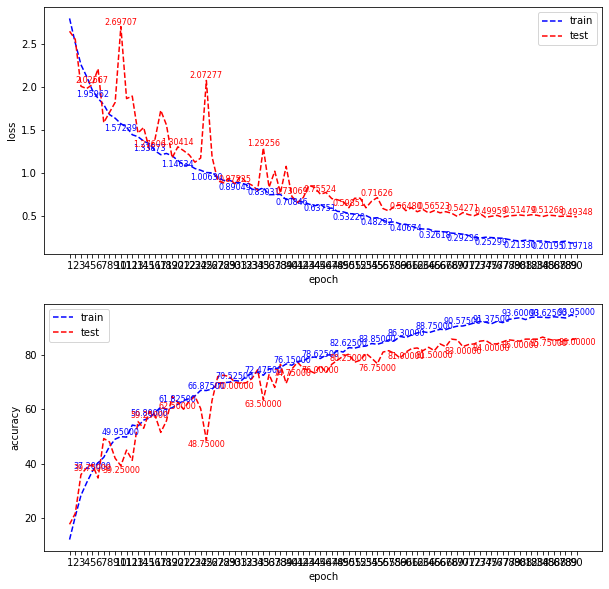

In [13]:
#visualize metric
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

x = [i for i in range(1, epochs+1)]

ax1.plot(x, train_loss_list, 'b--')
ax1.plot(x, test_loss_list, 'r--')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.legend(['train', 'test'])
ax1.set_xticks(x)
for i, v in enumerate(x):
    if (i+1)%5==0: ax1.text(v, train_loss_list[i], "{:0.5f}".format(train_loss_list[i]), fontsize = 8, color='blue', horizontalalignment='center', verticalalignment='top')
for i, v in enumerate(x):
    if (i+1)%5==0: ax1.text(v, test_loss_list[i], "{:0.5f}".format(test_loss_list[i]), fontsize = 8, color='red', horizontalalignment='center', verticalalignment='bottom')


ax2.plot(x, train_acc_list, 'b--')
ax2.plot(x, test_acc_list, 'r--')
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
ax2.legend(['train', 'test'])
ax2.set_xticks(x)
for i, v in enumerate(x):
    if (i+1)%5==0: ax2.text(v, train_acc_list[i], "{:0.5f}".format(train_acc_list[i]), fontsize = 8, color='blue', horizontalalignment='center', verticalalignment='bottom')
for i, v in enumerate(x):
    if (i+1)%5==0: ax2.text(v, test_acc_list[i], "{:0.5f}".format(test_acc_list[i]), fontsize = 8, color='red', horizontalalignment='center', verticalalignment='top')

plt.show()